## 项目说明

项目使用jqdaatasdk读取数据，该接口数据购买费用为3万/年，本项目已经用账号下载好了所需要的因子数据，耗时约6小时。在模型训练阶段，个别模型使用了超参数寻优，耗时1小时以上，为了节约时间，我已经将这些模型保存到了项目的`model_dir`目录中，在本项目中将自动读取本地缓存好的模型，当然也可以将model_dir做一个备份，然后移走，之后本项目将重新开始寻找参数，过程会较为漫长

In [ ]:
import jqdatasdk


class Config:
    JQ_USER = "xxxxx"
    JQ_PASSWORD = "xxxxx"


jqdatasdk.auth(Config.JQ_USER, Config.JQ_PASSWORD)

auth success 


In [ ]:
import datetime
import os
import pickle
import warnings
from datetime import datetime as dt
from functools import lru_cache
from time import time

from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six
import statsmodels.api as sm
from loguru import logger
from scipy import stats
from statsmodels import regression
from statsmodels.api import OLS

warnings.filterwarnings("ignore")
mpl.rcParams["font.family"] = "SimHei"
mpl.rcParams["axes.unicode_minus"] = False
plt.style.use("ggplot")

## 1. Prepare Data

### 1.1 Parameter setting

In [3]:
# 样本区间
START_DATE = "2010-01-01"
END_DATE = "2022-01-28"
# END_DATE = "2025-02-28"
# 指数成份股 ,比较基准 , 这里用沪深300
INDEX = "000300.XSHG"
# 排名前0.3为1,后0.3为0
percent_select = [0.3, 0.3]

### 1.2 Financial Data

In [4]:
q = jqdatasdk.query(
    jqdatasdk.valuation.code,
    jqdatasdk.valuation.market_cap,  # 市值
    jqdatasdk.valuation.circulating_market_cap,
    jqdatasdk.valuation.pe_ratio,  # 市盈率（TTM）
    jqdatasdk.valuation.pb_ratio,  # 市净率（TTM）
    jqdatasdk.valuation.pcf_ratio,  # CFP
    jqdatasdk.valuation.ps_ratio,  # PS
    jqdatasdk.balance.total_assets,
    jqdatasdk.balance.total_liability,
    jqdatasdk.balance.fixed_assets,
    jqdatasdk.balance.total_non_current_liability,
    jqdatasdk.income.operating_profit,
    jqdatasdk.income.total_profit,  # OPTP
    jqdatasdk.indicator.net_profit_to_total_revenue,  # 净利润/营业总收入
    jqdatasdk.indicator.inc_revenue_year_on_year,  # 营业收入增长率（同比）
    jqdatasdk.indicator.inc_net_profit_year_on_year,  # 净利润增长率（同比）
    jqdatasdk.indicator.roe,
    jqdatasdk.indicator.roa,
    jqdatasdk.indicator.gross_profit_margin,  # 销售毛利率GPM
)

### 1.3 Factor list

In [5]:
jqfactor_list = [
    "current_ratio",
    "net_profit_to_total_operate_revenue_ttm",
    "gross_income_ratio",
    "roe_ttm",
    "roa_ttm",
    "total_asset_turnover_rate",
    "net_operating_cash_flow_coverage",
    "net_operate_cash_flow_ttm",
    "net_profit_ttm",
    "cash_to_current_liability",
    "operating_revenue_growth_rate",
    "non_recurring_gain_loss",
    "operating_revenue_ttm",
    "net_profit_growth_rate",
    "AR",
    "ARBR",
    "ATR14",
    "VOL5",
    "VOL60",
    "Skewness20",
    "Skewness60",
]

### 1.4 Useful functions

In [6]:
def __warn(msg):
    logger.warning(msg)

In [ ]:
def get_trade_days_monthly(start, end):
    """
    :param start:
    :param end:
    :return:  list
    """
    index = jqdatasdk.get_trade_days(start_date=start, end_date=end)
    df = pd.DataFrame(index, index=index)
    df.index = pd.to_datetime(df.index)
    return list(df.resample("m").last().iloc[:, 0])

In [8]:
# 去除上市距截面期不足n天的股票
def remove_new(stocks, beginDate, n):
    stocklist = []
    if isinstance(beginDate, str):
        # str转datetime
        beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date = jqdatasdk.get_security_info(stock).start_date
        # 去除上市距截面期不足n天的股票
        if start_date < (beginDate - datetime.timedelta(days=n)):
            stocklist.append(stock)
    return stocklist

In [9]:
# 剔除ST股
def remove_st(stocks, beginDate):
    is_st = jqdatasdk.get_extras("is_st", stocks, end_date=beginDate, count=1)
    return [stock for stock in stocks if not is_st[stock][0]]

In [10]:
# 剔除每个截面期交易日停牌的股票
def remove_paused(stocks, beginDate):
    is_paused = jqdatasdk.get_price(
        stocks, end_date=beginDate, count=1, fields="paused", panel=False
    )
    return list(is_paused[is_paused["paused"] != 1]["code"])

In [11]:
def get_stocks_filtered(beginDate, n, indexID=INDEX):
    """
    获取某一天筛选后的指数成份股
    :param tradedate: 指定某一天
    :param indexID:默认'399905.XSHE'
    :param n : 剔除上市不到n天
    :return:
    """
    # 获取当天指数成份股列表
    stocklist = jqdatasdk.get_index_stocks(indexID, date=beginDate)
    stocklist = remove_new(stocklist, beginDate, n)
    stocklist = remove_st(stocklist, beginDate)
    stocklist = remove_paused(stocklist, beginDate)
    return stocklist

In [12]:
def get_df_jqfactor(stocklist, factor_list, date):
    """
    获取聚宽因子
    stocklist：list,股票列表
    factor_list:list,因子列表
    date: 日期， 字符串或 datetime 对象
    output:
    dataframe, index为股票代码，columns为因子
    """
    # 返回的是一个字典 {'因子1':df1,...}
    factor_data = jqdatasdk.get_factor_values(
        securities=stocklist, factors=factor_list, count=1, end_date=date
    )
    df_jqfactor = pd.DataFrame(index=stocklist)

    for factor in factor_data.keys():
        df_jqfactor[factor] = factor_data[factor].iloc[0, :]

    return df_jqfactor

In [13]:
def __convert_dt(date):
    if isinstance(date, datetime.datetime):
        return date
    elif isinstance(date, datetime.date):
        return date
    return dt.strptime(date, "%Y-%m-%d")


def __get_fq_ref_date(date=None):
    if date is not None:

        return convert_date(date)
    return datetime.date.today()


def BIAS(
    security_list,
    check_date,
    N1=6,
    N2=12,
    N3=24,
    unit="1d",
    include_now=True,
    fq_ref_date=None,
):
    """
    计算公式：
        BIAS1 : (CLOSE - MA(CLOSE, N1)) / MA(CLOSE, N1) * 100;
        BIAS2 : (CLOSE - MA(CLOSE, N2)) / MA(CLOSE, N2) * 100;
        BIAS3 : (CLOSE - MA(CLOSE, N3)) / MA(CLOSE, N3) * 100;
        输出 BIAS1 = (收盘价 - 收盘价的 N1 日简单移动平均) / 收盘价的 N1 日简单移动平均 * 100
        输出 BIAS2 = (收盘价 - 收盘价的 N2 日简单移动平均) / 收盘价的 N2 日简单移动平均 * 100
        输出 BIAS3 = (收盘价 - 收盘价的 N3 日简单移动平均) / 收盘价的 N3 日简单移动平均 * 100
    输入：
        security_list: 股票列表
        check_date：要查询数据的日期
        N1：统计的天数 N1
        N2: 统计的天数 N2
        N3: 统计的天数 N3
        unit：统计周期，默认为 '1d'
        include_now：是否包含当前周期，默认为 True
    输出：
        BIAS1, BIAS2, BIAS3 的值。
    输出结果类型：
        字典(dict)：键(key)为股票代码，值(value)为数据。
    """
    import numpy as np
    import six

    # 修复传入为单只股票的情况
    if isinstance(security_list, six.string_types):
        security_list = [security_list]

    # 转换 date 为 datetime
    check_date = __convert_dt(check_date)

    # 计算 BIAS
    bias1 = {}
    bias2 = {}
    bias3 = {}
    maxN = max(N1, N2, N3)

    for stock in security_list:
        security_data = jqdatasdk.get_bars(
            stock,
            end_dt=check_date,
            unit=unit,
            fields=["close"],
            include_now=include_now,
            count=maxN * 2,
            fq_ref_date=__get_fq_ref_date(fq_ref_date),
        )
        security_data = pd.DataFrame(
            security_data, index=range(maxN * 2 - len(security_data), maxN * 2)
        )
        security_data = security_data.reindex(range(maxN * 2))
        security_data.index = security_data.index.astype(str)
        nan_count = list(np.isnan(security_data["close"])).count(True)

        if nan_count == len(security_data["close"]):
            __warn(
                "股票 %s 输入数据全是 NaN，该股票可能已退市、未上市或刚上市，返回 NaN 值数据。"
                % str(stock)
            )
            bias1[stock] = np.nan
            bias2[stock] = np.nan
            bias3[stock] = np.nan
        else:
            if nan_count > 0:
                security_data.fillna(method="bfill", inplace=True)
            current_price = security_data["close"][-1]
            average_price = security_data["close"][-N1:].mean()
            bias1[stock] = (current_price - average_price) / average_price * 100.0

            average_price = security_data["close"][-N2:].mean()
            bias2[stock] = (current_price - average_price) / average_price * 100.0

            average_price = security_data["close"][-N3:].mean()
            bias3[stock] = (current_price - average_price) / average_price * 100.0

    return bias1, bias2, bias3


def RSI(security_list, check_date, N1=6, unit="1d", include_now=True, fq_ref_date=None):
    """
    计算公式：
        LC := REF(CLOSE, 1);
        RSI1: SMA(MAX(CLOSE - LC, 0), N1, 1) / SMA(ABS(CLOSE - LC), N1, 1) * 100;
        LC 赋值: 1 日前的收盘价
        输出 RSI1: 收盘价 - LC 和 0 的较大值的 N1 日 [1 日权重] 移动平均 / 收盘价 - LC 的绝对值的 N1 日 [1 日权重] 移动平均 * 100
    输入：
        security_list: 股票列表
        check_date：要查询数据的日期
        N1：统计的天数 N1
        unit：统计周期，默认为 '1d'
        include_now：是否包含当前周期，默认为 True
    输出：
        RSI 的值。
    输出结果类型：
        字典(dict)：键(key)为股票代码，值(value)为数据。
    """
    import numpy as np
    import six
    import talib

    # 修复传入为单只股票的情况
    if isinstance(security_list, six.string_types):
        security_list = [security_list]

    # 转换 date 为 datetime
    check_date = __convert_dt(check_date)

    # 计算 RSI
    rsi = {}
    for stock in security_list:
        security_data = jqdatasdk.get_bars(
            stock,
            end_dt=check_date,
            unit=unit,
            fields=["close"],
            include_now=include_now,
            count=N1 * 20,
            fq_ref_date=__get_fq_ref_date(fq_ref_date),
        )
        security_data = pd.DataFrame(
            security_data, index=range(N1 * 20 - len(security_data), N1 * 20)
        )
        security_data = security_data.reindex(range(N1 * 20))
        security_data.index = security_data.index.astype(str)
        nan_count = list(np.isnan(security_data["close"])).count(True)

        if nan_count == len(security_data["close"]):
            __warn(
                "股票 %s 输入数据全是 NaN，该股票可能已退市、未上市或刚上市，返回 NaN 值数据。"
                % str(stock)
            )
            rsi[stock] = np.nan
        else:
            if nan_count > 0:
                security_data.fillna(method="bfill", inplace=True)
            close_RSI = security_data["close"]
            rsi[stock] = talib.RSI(np.array(close_RSI), N1)[-1]

    return rsi


def PSY(
    security_list,
    check_date,
    timeperiod=12,
    unit="1d",
    include_now=True,
    fq_ref_date=None,
):
    """
    计算公式：
        PSY: 统计 N 日中满足收盘价 > 1日前的收盘价的天数 / N * 100
    输入：
        security_list: 股票列表
        check_date：要查询数据的日期
        timeperiod：统计的天数 N
        unit：统计周期，默认为 '1d'
        include_now：是否包含当前周期，默认为 True
    输出：
        PSY 的值。
    输出结果类型：
        字典(dict)：键(key)为股票代码，值(value)为数据。
    """
    import numpy as np
    import six

    # 修复传入为单只股票的情况
    if isinstance(security_list, six.string_types):
        security_list = [security_list]

    # 转换 date 为 datetime
    check_date = __convert_dt(check_date)

    # 计算 PSY
    psy = {}
    for stock in security_list:
        security_data = jqdatasdk.get_bars(
            stock,
            end_dt=check_date,
            unit=unit,
            fields=["close"],
            include_now=include_now,
            count=timeperiod + 1,
            fq_ref_date=__get_fq_ref_date(fq_ref_date),
        )
        security_data = pd.DataFrame(
            security_data,
            index=range(timeperiod + 1 - len(security_data), timeperiod + 1),
        )
        security_data = security_data.reindex(range(timeperiod + 1))
        security_data.index = security_data.index.astype(str)
        nan_count = list(np.isnan(security_data["close"])).count(True)

        if nan_count == len(security_data["close"]):
            __warn(
                "股票 %s 输入数据全是 NaN，该股票可能已退市、未上市或刚上市，返回 NaN 值数据。"
                % str(stock)
            )
            psy[stock] = np.nan
        else:
            if nan_count > 0:
                security_data.fillna(method="bfill", inplace=True)
            close_PSY = security_data["close"]
            psy_dif = np.diff(close_PSY)[-timeperiod:]
            psy_sign = np.where(psy_dif > 0, 1.0, 0)
            Sum = np.sum(psy_sign)
            psy[stock] = Sum / timeperiod * 100

    return psy


def MACD(
    security_list,
    check_date,
    SHORT=12,
    LONG=26,
    MID=9,
    unit="1d",
    include_now=True,
    fq_ref_date=None,
):
    """
    计算公式：
        DIF:EMA(CLOSE,SHORT)-EMA(CLOSE,LONG);
        DEA:EMA(DIF,MID);
        MACD:(DIF-DEA)*2,COLORSTICK;
        输出DIF = 收盘价的SHORT日指数移动平均-收盘价的LONG日指数移动平均
        输出DEA = DIF的MID日指数移动平均
        输出平滑异同平均 = (DIF-DEA)*2,COLORSTICK
    输入：
        security_list:股票列表
        check_date：要查询数据的日期
        SHORT：统计的天数 SHORT
        LONG：统计的天数 LONG
        MID：统计的天数 MID
        unit：统计周期，默认为 '1d'
        include_now：是否包含当前周期，默认为 True
    输出：
        DIF, DEA和MACD的值。
    输出结果类型：
        字典(dict)：键(key)为股票代码，值(value)为数据。
    """
    import numpy as np
    import six
    import talib

    # 修复传入为单只股票的情况
    if isinstance(security_list, six.string_types):
        security_list = [security_list]

    # 转换 date 为 datetime
    check_date = __convert_dt(check_date)

    # 计算 MACD
    macd_dif = {}
    macd_dea = {}
    macd_macd = {}

    for stock in security_list:
        security_data = jqdatasdk.get_bars(
            stock,
            end_dt=check_date,
            unit=unit,
            fields=["close"],
            include_now=include_now,
            count=SHORT * 20,
            fq_ref_date=__get_fq_ref_date(fq_ref_date),
        )
        security_data = pd.DataFrame(
            security_data, index=range(SHORT * 20 - len(security_data), SHORT * 20)
        )
        security_data = security_data.reindex(range(SHORT * 20))
        security_data.index = security_data.index.astype(str)
        nan_count = list(np.isnan(security_data["close"])).count(True)

        if nan_count == len(security_data["close"]):
            __warn(
                "股票 %s 输入数据全是 NaN，该股票可能已退市、未上市或刚上市，返回 NaN 值数据。"
                % str(stock)
            )
            macd_dif[stock] = np.nan
            macd_dea[stock] = np.nan
            macd_macd[stock] = np.nan
        else:
            if nan_count > 0:
                security_data.fillna(method="bfill", inplace=True)
            close_macd = security_data["close"]

            # 调用talib的MACD函数，获取到dif, dea的列表
            dic = talib.MACD(
                np.array(close_macd),
                fastperiod=SHORT,
                slowperiod=LONG,
                signalperiod=MID,
            )
            macd_dif[stock] = dic[0][-1]
            macd_dea[stock] = dic[1][-1]
            # 计算平滑移动平均macd
            macd_macd[stock] = (macd_dif[stock] - macd_dea[stock]) * 2

    return macd_dif, macd_dea, macd_macd


def mean(a, axis=None, dtype=None, out=None, keepdims=np._NoValue):
    """
    Compute the arithmetic mean along the specified axis.

    Returns the average of the array elements. The average is taken over
    the flattened array by default, otherwise over the specified axis.
    `float64` intermediate and return values are used for integer inputs.

    Parameters
    ----------
    a : array_like
        Array containing numbers whose mean is desired. If `a` is not an
        array, a conversion is attempted.
    axis : None or int or tuple of ints, optional
        Axis or axes along which the means are computed. The default is to
        compute the mean of the flattened array.

        .. versionadded:: 1.7.0

        If this is a tuple of ints, a mean is performed over multiple axes,
        instead of a single axis or all the axes as before.
    dtype : data-type, optional
        Type to use in computing the mean. For integer inputs, the default
        is `float64`; for floating point inputs, it is the same as the
        input dtype.
    out : ndarray, optional
        Alternate output array in which to place the result. The default
        is ``None``; if provided, it must have the same shape as the
        expected output, but the type will be cast if necessary.
        See `doc.ufuncs` for details.
    keepdims : bool, optional
        If this is set to True, the axes which are reduced are left
        in the result as dimensions with size one. With this option,
        the result will broadcast correctly against the input array.

        If the default value is passed, then `keepdims` will not be
        passed through to the `mean` method of sub-classes of
        `ndarray`, however any non-default value will be. If the
        sub-classes `sum` method does not implement `keepdims` any
        exceptions will be raised.

    Returns
    -------
    m : ndarray, see dtype parameter above
        If `out=None`, returns a new array containing the mean values,
        otherwise a reference to the output array is returned.

    See Also
    --------
    average : Weighted average
    std, var, nanmean, nanstd, nanvar

    Notes
    -----
    The arithmetic mean is the sum of the elements along the axis divided
    by the number of elements.

    Note that for floating-point input, the mean is computed using the
    same precision the input has. Depending on the input data, this can
    cause the results to be inaccurate, especially for `float32` (see
    example below). Specifying a higher-precision accumulator using the
    `dtype` keyword can alleviate this issue.

    By default, `float16` results are computed using `float32` intermediates
    for extra precision.

    Examples
    --------
    >>> a = np.array([[1, 2], [3, 4]])
    >>> np.mean(a)
    2.5
    >>> np.mean(a, axis=0)
    array([ 2.,  3.])
    >>> np.mean(a, axis=1)
    array([ 1.5,  3.5])

    In single precision, `mean` can be inaccurate:
    >>> a = np.zeros((2, 512 * 512), dtype=np.float32)
    >>> a[0, :] = 1.0
    >>> a[1, :] = 0.1
    >>> np.mean(a)
    0.54999924

    Computing the mean in float64 is more accurate:
    >>> np.mean(a, dtype=np.float64)
    0.55000000074505806
    """
    kwargs = {}
    if keepdims is not np._NoValue:
        kwargs["keepdims"] = keepdims
    if type(a) is not np.ndarray:
        try:
            mean = a.mean
        except AttributeError:
            pass
        else:
            return mean(axis=axis, dtype=dtype, out=out, **kwargs)

    return _methods._mean(a, axis=axis, dtype=dtype, out=out, **kwargs)

In [25]:
DateTime = datetime.datetime
Date = datetime.date
Time = datetime.time
TimeDelta = datetime.timedelta

today = datetime.date.today
now = datetime.datetime.now


def convert_date(date):
    """转换多种日期类型为 datetime.date 类型"""
    if isinstance(date, __import__("pandas").Timestamp):
        date = str(date)

    if isinstance(date, six.string_types):
        if ":" in date:
            date = date[:10]
        with suppress(ValueError):
            return Date(*map(int, date.split("-")))
    elif isinstance(date, datetime.datetime):
        return date.date()
    elif isinstance(date, datetime.date):
        return date
    raise ValueError(
        "date must be datetime.date, datetime.datetime, "
        "pandas.Timestamp or as '2015-01-05'"
    )


class suppress(object):
    """Context manager to suppress specified exceptions

    After the exception is suppressed, execution proceeds with the next
    statement following the with statement.
         with suppress(FileNotFoundError):
             os.remove(somefile)
         # Execution still resumes here if the file was already removed

    copy from https://github.com/jazzband/contextlib2
    """

    def __init__(self, *exceptions):
        self._exceptions = exceptions

    def __enter__(self):
        pass

    def __exit__(self, exctype, excinst, exctb):
        return exctype is not None and issubclass(exctype, self._exceptions)

In [26]:
@lru_cache(10)
def get_ind_record(industry):
    mapping = jqdatasdk.get_industries(industry).to_dict()["name"]
    ind_record = jqdatasdk.get_history_industry(industry).set_index("stock")
    ind_record["industry_name"] = ind_record["code"].map(mapping)
    ind_record.end_date = ind_record.end_date.fillna(Date(2040, 1, 1))
    return ind_record

In [27]:
def get_newfactors_df(stocklist, df, date):
    """
    stocklist: 股票列表
    df : 原始因子df
    date : 日期
    return : 新的因子df

    """

    # 净资产
    df["net_assets"] = df["total_assets"] - df["total_liability"]
    df_new = pd.DataFrame(index=stocklist)

    # 估值因子
    df_new["EP"] = df["pe_ratio"].apply(lambda x: 1 / x)
    df_new["BP"] = df["pb_ratio"].apply(lambda x: 1 / x)
    df_new["SP"] = df["ps_ratio"].apply(lambda x: 1 / x)
    #     df_new['RD'] = df['development_expenditure']/(df['market_cap']*100000000)
    df_new["CFP"] = df["pcf_ratio"].apply(lambda x: 1 / x)

    # 杠杆因子
    # 对数流通市值
    #     df_new['CMV'] = np.log(df['circulating_market_cap'])
    # 总资产/净资产
    df_new["financial_leverage"] = df["total_assets"] / df["net_assets"]
    # 非流动负债/净资产
    df_new["debtequityratio"] = df["total_non_current_liability"] / df["net_assets"]
    # 现金比率=(货币资金+有价证券)÷流动负债
    df_new["cashratio"] = df["cash_to_current_liability"]
    # 流动比率=流动资产/流动负债*100%
    df_new["currentratio"] = df["current_ratio"]

    # 财务质量因子
    # 净利润与营业总收入之比
    df_new["NI"] = df["net_profit_to_total_operate_revenue_ttm"]
    df_new["GPM"] = df["gross_income_ratio"]
    df_new["ROE"] = df["roe_ttm"]
    df_new["ROA"] = df["roa_ttm"]
    df_new["asset_turnover"] = df["total_asset_turnover_rate"]
    df_new["net_operating_cash_flow"] = df["net_operating_cash_flow_coverage"]

    # 成长因子
    df_new["Sales_G_q"] = df["operating_revenue_growth_rate"]
    df_new["Profit_G_q"] = df["net_profit_growth_rate"]
    #     df_new['PEG'] = df['PEG']

    # 技术指标
    df_new["RSI"] = pd.Series(RSI(stocklist, date, N1=20))
    df_new["BIAS"] = pd.Series(BIAS(stocklist, date, N1=20)[0])
    df_new["PSY"] = pd.Series(PSY(stocklist, date, timeperiod=20))

    dif, dea, macd = MACD(stocklist, date, SHORT=10, LONG=30, MID=15)
    df_new["DIF"] = pd.Series(dif)
    df_new["DEA"] = pd.Series(dea)
    df_new["MACD"] = pd.Series(macd)
    df_new["AR"] = df["AR"]
    df_new["ARBR"] = df["ARBR"]
    df_new["ATR14"] = df["ATR14"]
    df_new["ARBR"] = df["ARBR"]

    df_new["VOL5"] = df["VOL5"]
    df_new["VOL60"] = df["VOL60"]

    # 风险因子
    df_new["Skewness20"] = df["Skewness20"]
    df_new["Skewness60"] = df["Skewness60"]

    return df_new

In [28]:
from tenacity import retry, stop_after_attempt, wait_exponential


@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=2, max=30))
def get_all_factors_dict(trade_days, q):
    original_factor_dict = {}

    folder = "factor_data4ML"
    exist_folder = [d for d in os.listdir(folder) if len(d) == 8]
    for date in trade_days:
        print("date:", date)
        date_str = date.strftime("%Y%m%d")
        folder_path = os.path.join(folder, date_str)
        file_name = os.path.join(folder_path, f"original_factor_{date_str}.csv")
        if date_str in exist_folder:
            tmp_mat = pd.read_csv(file_name)
            tmp_mat.rename(columns={tmp_mat.columns[0]: "stock"}, inplace=True)
            tmp_mat.set_index("stock", inplace=True)
            original_factor_dict[date] = tmp_mat
            continue
        stocklist = get_stocks_filtered(date, 90, indexID=INDEX)
        # 获取财务数据
        q_new = q.filter(jqdatasdk.valuation.code.in_(stocklist))
        q_factor = jqdatasdk.get_fundamentals(q_new, date=date)
        q_factor.set_index("code", inplace=True)
        print(len(q_factor.index))
        # 获取聚宽因子库数据
        df_jqfactor = get_df_jqfactor(stocklist, jqfactor_list, date)
        # 两表合并
        original_factor_dict[date] = get_newfactors_df(
            stocklist, pd.concat([q_factor, df_jqfactor], axis=1), date
        )

        os.mkdir(folder_path)
        original_factor_dict[date].to_csv(file_name)

        print("获取数据成功!")
        print("=" * 30)
    return original_factor_dict

In [29]:
# 交易日期
trade_days_all = get_trade_days_monthly(START_DATE, END_DATE)
# 分测试集
trade_days_test = trade_days_all[88:]

In [30]:
# # 初次导数据用时半小时
start = time()
original_factor_dict = get_all_factors_dict(trade_days_all, q)
end = time()
print(datetime.datetime.fromtimestamp(end - start).strftime("%M:%S:%f"))

date: 2010-01-29
date: 2010-02-26
date: 2010-03-31
date: 2010-04-30
date: 2010-05-31
date: 2010-06-30
date: 2010-07-30
date: 2010-08-31
date: 2010-09-30
date: 2010-10-29
date: 2010-11-30
date: 2010-12-31
date: 2011-01-31
date: 2011-02-28
date: 2011-03-31
date: 2011-04-29
date: 2011-05-31
date: 2011-06-30
date: 2011-07-29
date: 2011-08-31
date: 2011-09-30
date: 2011-10-31
date: 2011-11-30
date: 2011-12-30
date: 2012-01-31
date: 2012-02-29
date: 2012-03-30
date: 2012-04-27
date: 2012-05-31
date: 2012-06-29
date: 2012-07-31
date: 2012-08-31
date: 2012-09-28
date: 2012-10-31
date: 2012-11-30
date: 2012-12-31
date: 2013-01-31
date: 2013-02-28
date: 2013-03-29
date: 2013-04-26
date: 2013-05-31
date: 2013-06-28
date: 2013-07-31
date: 2013-08-30
date: 2013-09-30
date: 2013-10-31
date: 2013-11-29
date: 2013-12-31
date: 2014-01-30
date: 2014-02-28
date: 2014-03-31
date: 2014-04-30
date: 2014-05-30
date: 2014-06-30
date: 2014-07-31
date: 2014-08-29
date: 2014-09-30
date: 2014-10-31
date: 2014-11-

## 2. Data Preprocessing

- Median-based Outlier Removal
- Missing Value Imputation
- Industry and Market Capitalization Neutralization
- Standardization
- PCA (Principal Component Analysis) Dimensionality Reduction

In [31]:
def fillwith_industry_mean(df, date, industry="sw_l1"):
    """
    df: 因子数据
    date:日期
    return: 填充空值后的df
    """
    stocklist = df.index.tolist()
    # 获得股票所属行业
    industry_dict = jqdatasdk.get_industry(stocklist, date=date)
    industry_stock = {}
    for k, v in industry_dict.items():
        if "sw_l1" in v.keys():
            industry_stock[k] = v["sw_l1"]["industry_name"]
        else:
            # 有的股票没有sw_l1行业
            industry_stock[k] = np.nan
    df["industry"] = pd.Series(industry_stock)

    # 行业均值df ,index为行业,列为因子,值为均值
    industry_mean_df = df.loc[df["industry"].notnull()].groupby("industry").mean()
    for factor in df.columns:
        # 获得该因子为空的股票
        null_codes = df.loc[df[factor].isnull(), factor].index.tolist()

        for code in null_codes:
            # 如果知道股票所属行业, 不是np.nan
            if isinstance(df.loc[code, "industry"], str):
                df.loc[code, factor] = industry_mean_df.loc[
                    df.loc[code, "industry"], factor
                ]
    # 无行业用列均值填充
    df.fillna(df.mean(), inplace=True)
    return df.iloc[:, :-1]


def factor_processing(df, date, industry="sw_l1"):
    # 中位数去极值
    df = winsorize_med(df, scale=5, inf2nan=False, axis=0)
    # 行业均值填充缺失值
    df = fillwith_industry_mean(df, date, industry)
    # 行业市值中性化
    df = neutralize(df, ["sw_l1", "mktcap"], date=str(date), axis=0)
    # 标准化
    df = standardlize(df, axis=0)
    return df

In [32]:
def winsorize_med(data, scale=1, inclusive=True, inf2nan=True, axis=1):
    if isinstance(data, pd.DataFrame):
        # print('===df========')
        return data.apply(
            winsorize_med, axis, scale=scale, inclusive=inclusive, inf2nan=inf2nan
        )
    elif isinstance(data, np.ndarray) and data.ndim > 1:
        # print('===array========')
        return np.apply_along_axis(
            winsorize_med,
            axis,
            arr=data,
            scale=scale,
            inclusive=inclusive,
            inf2nan=inf2nan,
        )
    if isinstance(data, pd.Series):
        # print('===Series========')
        v = data.values
        # print('vvvvvv')
    else:
        # print('===esle========')
        v = data
    # print('v:', v)
    if not np.isfinite(v).any():
        return data
    # 如果v是int arrary，无法给 array 赋值 np.nan，因为 np.nan 是个 float
    v = v.astype(float)
    if inf2nan:
        v[~np.isfinite(v)] = np.nan
    med = np.median(v[~np.isnan(v)])
    data_minus_med = v[~np.isnan(v)] - med
    median_absolute = np.median(np.abs(data_minus_med))
    if inclusive:
        not_nan = ~np.isnan(v)
        v[not_nan] = np.where(
            v[not_nan] > med + scale * median_absolute,
            med + scale * median_absolute,
            v[not_nan],
        )
        not_nan = ~np.isnan(v)
        v[not_nan] = np.where(
            v[not_nan] < med - scale * median_absolute,
            med - scale * median_absolute,
            v[not_nan],
        )
    else:
        # 如果v是int arrary，np.nan 会被转换成一个极小的数，比如 -2147483648
        v = v.astype(float)
        not_nan = ~np.isnan(v)
        v_not_nan = v[not_nan]
        v[not_nan] = np.where(
            np.logical_and(
                v_not_nan <= med + scale * median_absolute,
                v_not_nan >= med - scale * median_absolute,
            ),
            v_not_nan,
            np.nan,
        )
    if isinstance(data, pd.Series):
        return pd.Series(v, index=data.index)
    else:
        return v


def neutralize(data, how=None, date=None, axis=1, fillna=None, add_constant=False):
    """中性化
    data: pd.Series/pd.DataFrame, 待中性化的序列, 序列的 index/columns 为股票的 code
    how: str list. 中性化使用的因子名称列表. 默认为 ['jq_l1', 'market_cap'], 支持的中性化方法有:
                1. 行业: sw_l1, sw_l2, sw_l3
                2. 市值因子: mktcap(总市值), ln_mktcap(对数总市值), cmktcap(流通市值), ln_cmktcap(对数流通市值)
                3. 自定义的中性化数据: 支持同时传入额外的 Series 或者 DataFrame 用来进行中性化, index 必须是标的代码
                以上三类参数可同时传入参数列表
    date: 日期, 将用 date 这天的相关变量数据对 series 进行中性化 (注意依赖数据的实际可用时间, 如市值数据当天盘中是无法获取到的)
    axis: 默认为 1. 仅在 data 为 pd.DataFrame 时生效. 表示沿哪个方向做中性化, 0 为对每列做中性化, 1 为对每行做中性化
    fillna: 缺失值填充方式, 默认为None, 表示不填充. 支持的值:
        'sw_l1': 申万一级行业
        'sw_l2': 申万二级行业
        'sw_l3': 申万三级行业 表示使用某行业分类的均值进行填充.
    add_constant: 中性化时是否添加常数项, 默认为 False
    """
    if data.dropna(how="all").empty:
        return data

    if how is None:
        how = ["jq_l1", "mktcap"]
    elif isinstance(how, str):
        how = [how]

    if isinstance(data, pd.Series) or axis == 0:
        securities = data.index.astype(str)
    else:
        securities = data.columns.astype(str)
    invalid_securities = securities[
        ~(securities.str.endswith("XSHG") | securities.str.endswith("XSHE"))
    ].tolist()
    if invalid_securities:
        raise ValueError(
            "neutralize: 找不到股票: {sym:s}".format(sym=str(invalid_securities))
        )

    exposure = get_neu_basicdata(how, securities.tolist(), date=date)

    with pd.option_context("mode.use_inf_as_null", True):
        exposure.dropna(axis=1, how="all", inplace=True)
        exposure.dropna(inplace=True)
        exposure = exposure.astype(np.float64)

    if exposure.empty:
        return data

    if fillna is not None:
        dataapi = cache_dataapi()
        ind = dataapi._get_cached_industry_one_day(date, securities)

    def valid_index(s):
        return s[np.isfinite(s)].index.intersection(exposure.index)

    def get_resid(s):
        valid_index_ = valid_index(s)
        if len(valid_index_) > 1:
            resid = (
                OLS(
                    s.loc[valid_index_].values,
                    (
                        sm_add_constant(exposure.loc[valid_index_].values)
                        if add_constant
                        else exposure.loc[valid_index_].values
                    ),
                    missing="drop",
                )
                .fit()
                .resid
            )
            resid = pd.Series(resid, index=valid_index_)
            resid = resid.reindex(s.index, fill_value=np.nan)
            if fillna is not None:
                resid = resid.groupby(ind.loc[s.index]).apply(
                    lambda x: x.fillna(x.mean())
                )
        else:
            resid = pd.Series(np.nan, index=s.index)
        return resid

    if isinstance(data, pd.Series):
        return get_resid(data)
    else:
        return data.apply(get_resid, axis)


def standardlize(data, inf2nan=True, axis=1):
    if inf2nan:
        data = data.astype("float64")
        data[np.isinf(data)] = np.nan

    axis = min(data.ndim - 1, axis)

    if not np.any(np.isfinite(data)):
        return data

    mu = np.nanmean(np.where(~np.isinf(data), data, np.nan), axis=axis)
    std = np.nanstd(np.where(~np.isinf(data), data, np.nan), axis=axis)

    rep = np.tile if axis == 0 else np.repeat
    mu = np.asarray(rep(mu, data.shape[axis])).reshape(data.shape)
    std = np.asarray(rep(std, data.shape[axis])).reshape(data.shape)

    if isinstance(data, (pd.Series, pd.DataFrame)):
        data = data.where(np.isinf(data), (data - mu) / std)
    else:
        data = np.where(np.isinf(data), data, (data - mu) / std)
    return data

In [33]:
def date2str(date, format="%Y-%m-%d"):
    return pd.to_datetime(date).strftime(format)


@lru_cache(maxsize=None)
def _get_trade_days(start_date=None, end_date=None):
    if start_date is not None:
        start_date = date2str(start_date)
    if end_date is not None:
        end_date = date2str(end_date)
    return list(jqdatasdk.get_trade_days(start_date=start_date, end_date=end_date))


@lru_cache(maxsize=None)
def get_ind_record(industry):
    print("industry:", industry)
    mapping = jqdatasdk.get_industries(industry).to_dict()["name"]
    ind_record = jqdatasdk.get_history_industry(industry).set_index("stock")
    ind_record["industry_name"] = ind_record["code"].map(mapping)
    ind_record.end_date = ind_record.end_date.fillna(Date(2040, 1, 1))
    return ind_record


def _get_cached_industry_one_day(date, securities=None, industry=None):
    date = convert_date(date)
    allow_industry_cache = False
    if allow_industry_cache:
        ind_record = get_ind_record(industry)
        if securities is not None:
            ind_record = ind_record[ind_record.index.isin(securities)]
        return ind_record[
            (ind_record.start_date <= date) & (date <= ind_record.end_date)
        ].code
    else:
        ind_record = jqdatasdk.get_industry(securities, date, df=True)
        ind_record = (
            ind_record[ind_record["type"] == industry].set_index("code").industry_code
        )
        return ind_record


def _get_cached_mkt_cap_by_valuation(securities, date, field, overwrite=False):
    """市值处理函数, 将获取的市值数据缓存到本地"""
    if not securities:
        return pd.Series(dtype="float64", name=date)

    query = jqdatasdk.query
    valuation = jqdatasdk.valuation
    cache_dir = os.path.join(get_cache_dir(), "mkt_cap", date.strftime("%Y%m"))
    fp = os.path.join(cache_dir, date.strftime("%Y%m%d")) + ".feather"

    if os.path.exists(fp) and not overwrite:
        data = feather.read_feather(fp)
    else:
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        codes = jqdatasdk.get_all_securities("stock").index.tolist()
        q = query(
            valuation.code, valuation.market_cap, valuation.circulating_market_cap
        ).filter(valuation.code.in_(codes))
        data = jqdatasdk.get_fundamentals(q, date=date2str(date))
        data[["market_cap", "circulating_market_cap"]] = data[
            ["market_cap", "circulating_market_cap"]
        ] * (10**8)
        if date < today() or (date == today() and now().time() >= Time(16, 30)):
            data.to_feather(fp)

    return data[data.code.isin(securities)].set_index("code")[field]


def _get_market_cap(securities, start_date, end_date, ln=False, field="market_cap"):
    trade_days = _get_trade_days(start_date, end_date)

    def get_mkt_cap(s, date, field):
        if not s:
            return pd.Series(dtype="float64", name=date)
        data = jqdatasdk.get_fundamentals(q, date=date2str(date)).set_index("code")[
            field
        ] * (10**8)
        return data

    def get_mkt_cap_cache(s, date, field):
        cap = get_factor_values_by_cache(
            date, securities, factor_path=cache_dir
        ).reindex(columns=[field])
        return cap[field]

    # if self.allow_cache and len(trade_days) > 5:
    #     if mkt_cache_api == 'factor':
    #         desc = 'check/save cap cache :' if self.show_progress else False
    #         cache_dir = save_factor_values_by_group(start_date,
    #                                                 end_date,
    #                                                 factor_names=['market_cap', 'circulating_market_cap'],
    #                                                 group_name='mkt_cap',
    #                                                 show_progress=desc)
    #         market_api = get_mkt_cap_cache
    #     else:
    #         market_api = _get_cached_mkt_cap_by_valuation
    # else:
    market_api = get_mkt_cap
    query = jqdatasdk.query
    valuation = jqdatasdk.valuation

    if field == "market_cap":
        q = query(valuation.code, valuation.market_cap).filter(
            valuation.code.in_(securities)
        )
    elif field == "circulating_market_cap":
        q = query(valuation.code, valuation.circulating_market_cap).filter(
            valuation.code.in_(securities)
        )
    else:
        raise ValueError("不支持的字段 : {}".foramt(field))

    # if self.show_progress:
    #     trade_days = tqdm(trade_days, desc="load cap info : ")

    market_cap = []
    for date in trade_days:
        cap = market_api(securities, date, field)
        cap.name = date
        market_cap.append(cap)
    market_cap = pd.concat(market_cap, axis=1).astype(float).reindex(index=securities)

    if ln:
        market_cap = np.log(market_cap)

    return market_cap.T


def get_neu_basicdata(how, securities, date=None):
    """获取中性化的依赖数据
    返回: 一个 DataFrame, index 是股票代码
    """
    if isinstance(how, str):
        how = [how]

    if isinstance(how, (pd.Series, pd.DataFrame)):
        return how
    elif isinstance(how, (list, tuple)):
        how_datas = []
    else:
        raise ValueError("错误的 how 参数格式 : {}".format(how))

    # dataapi = cache_dataapi()
    for how_name in how:
        if isinstance(how_name, pd.Series):
            how_datas.append(how_name.to_frame())
        elif isinstance(how_name, pd.DataFrame):
            how_datas.append(how_name)
        elif how_name in ["jq_l1", "jq_l2", "sw_l1", "sw_l2", "sw_l3", "zjw"]:
            industry_info = pd.get_dummies(
                _get_cached_industry_one_day(date, securities, industry=how_name)
            ).reindex(securities, fill_value=0)
            how_datas.append(industry_info)
        elif how_name in ["mktcap", "ln_mktcap", "cmktcap", "ln_cmktcap"]:
            if how_name == "mktcap":
                mkt_api = partial(_get_market_cap, ln=False)
            elif how_name == "ln_mktcap":
                mkt_api = partial(_get_market_cap, ln=True)
            elif how_name == "cmktcap":
                mkt_api = partial(_get_circulating_market_cap, ln=False)
            elif how_name == "ln_cmktcap":
                mkt_api = partial(_get_circulating_market_cap, ln=True)

            market_info = mkt_api(
                securities=securities, start_date=date, end_date=date
            ).T
            market_info.columns = [how_name]
            how_datas.append(market_info)
        else:
            raise ValueError("不支持的因子名称 : {} ".format(how_name))

    return pd.concat(how_datas, axis=1)

In [34]:
# # 已经保存了处理好的数据,可以直接使用,这一步只需运行一次
processed_factor_dict = {}
folder = "processed_factor_data"
exist_folder = [d for d in os.listdir(folder) if len(d) == 8]
for date, factor_df in original_factor_dict.items():
    print("date:", date)
    date_str = date.strftime("%Y%m%d")
    folder_path = os.path.join(folder, date_str)
    file_name = os.path.join(folder_path, f"processed_factor_{date_str}.csv")
    if date_str in exist_folder:
        tmp_mat = pd.read_csv(file_name)
        tmp_mat.rename(columns={tmp_mat.columns[0]: "stock"}, inplace=True)
        tmp_mat.set_index("stock", inplace=True)
        processed_factor_dict[date] = tmp_mat
        continue
    processed_df = factor_processing(factor_df, date)
    processed_df.dropna(inplace=True)

    processed_factor_dict[date] = processed_df
    os.mkdir(folder_path)
    processed_factor_dict[date].to_csv(file_name)

date: 2010-01-29
date: 2010-02-26
date: 2010-03-31
date: 2010-04-30
date: 2010-05-31
date: 2010-06-30
date: 2010-07-30
date: 2010-08-31
date: 2010-09-30
date: 2010-10-29
date: 2010-11-30
date: 2010-12-31
date: 2011-01-31
date: 2011-02-28
date: 2011-03-31
date: 2011-04-29
date: 2011-05-31
date: 2011-06-30
date: 2011-07-29
date: 2011-08-31
date: 2011-09-30
date: 2011-10-31
date: 2011-11-30
date: 2011-12-30
date: 2012-01-31
date: 2012-02-29
date: 2012-03-30
date: 2012-04-27
date: 2012-05-31
date: 2012-06-29
date: 2012-07-31
date: 2012-08-31
date: 2012-09-28
date: 2012-10-31
date: 2012-11-30
date: 2012-12-31
date: 2013-01-31
date: 2013-02-28
date: 2013-03-29
date: 2013-04-26
date: 2013-05-31
date: 2013-06-28
date: 2013-07-31
date: 2013-08-30
date: 2013-09-30
date: 2013-10-31
date: 2013-11-29
date: 2013-12-31
date: 2014-01-30
date: 2014-02-28
date: 2014-03-31
date: 2014-04-30
date: 2014-05-30
date: 2014-06-30
date: 2014-07-31
date: 2014-08-29
date: 2014-09-30
date: 2014-10-31
date: 2014-11-

## 3. Generating Training and Test Sets

### 3.1 Calculate the monthly return

In [36]:
def get_return_monthly(stocklist, start, end):
    close_start = jqdatasdk.get_price(
        stocklist, count=1, end_date=start, fields="close", panel=False
    ).set_index("code")[["close"]]
    close_end = jqdatasdk.get_price(
        stocklist, count=1, end_date=end, fields="close", panel=False
    ).set_index("code")[["close"]]
    df = pd.concat([close_start, close_end], axis=1)
    df["return"] = (df.iloc[:, 1] - df.iloc[:, 0]) / df.iloc[:, 0]
    return df["return"]

In [37]:
def label_data(data, dropna=True):
    """将数据打标签,收益前0.3为1,后0.3为0"""
    # 初始化分类列
    data["return_bin"] = np.nan
    # 将下期收益从大到小排序
    data = data.sort_values(by="return", ascending=False)
    # [总样本*前0.3,总样本*后0.3]
    n_stock_select = np.multiply(percent_select, data.shape[0])
    # 取整操作
    # 取整后虽然数值为整数，但是在存储格式上仍为浮点数，
    # 因此还需要使用 astype(int)强制转换成整数格式。
    n_stock_select = np.around(n_stock_select).astype(int)
    # 收益前30% 赋值1,后30%赋值0
    data.iloc[: n_stock_select[0], -1] = 1
    data.iloc[-n_stock_select[1] :, -1] = 0
    if dropna:
        data.drop("return", axis=1, inplace=True)
        data = data.dropna()
    return data

In [38]:
# # 同样这里可以直接使用处理好的训练数据
# # 训练集合并
# # 这里取前88个月作为训练集 , 后36个月作为测试集
train_df_all = pd.DataFrame()
for idx, date in enumerate(trade_days_all[:88]):
    df = processed_factor_dict[date].copy()
    df["return"] = get_return_monthly(df.index.tolist(), date, trade_days_all[idx + 1])
    df = label_data(df)
    train_df_all = pd.concat([train_df_all, df])

In [39]:
test_dict = {}
for idx, date in enumerate(trade_days_test[:-1]):
    df = processed_factor_dict[date].copy()
    df["return"] = get_return_monthly(df.index.tolist(), date, trade_days_test[idx + 1])
    df = label_data(df, dropna=False)
    test_dict[date] = df

## 4.Feature Engineering

In [40]:
# 提取特征
X = train_df_all.iloc[:, :-1]
# 提取标签
y = train_df_all["return_bin"]

In [41]:
X

,EP,BP,SP,CFP,financial_leverage,debtequityratio,cashratio,currentratio,NI,GPM,...,DIF,DEA,MACD,AR,ARBR,ATR14,VOL5,VOL60,Skewness20,Skewness60
stock,,,,,,,,,,,,,,,,,,,,,
600158.XSHG,-0.404819,-0.676637,-0.014718,0.535832,0.014275,-1.161903,0.842116,0.148017,-0.185740,0.783505,...,1.595211,1.357524,0.643663,2.499653,0.614825,-0.104030,2.132847,2.389028,0.937812,0.934860
600118.XSHG,-0.115461,-0.812685,-1.600149,-0.705687,-0.770418,-0.683036,-1.319803,0.750699,0.270050,-0.100467,...,2.365872,2.401489,0.383193,3.230331,0.862718,0.599935,1.468039,1.772234,0.499106,-0.000458
000897.XSHE,-1.321716,-0.427481,-0.235163,-0.627228,0.065258,0.977078,-0.596748,0.310694,-1.650451,-1.566710,...,0.735273,0.902070,-0.192747,1.039708,-0.916652,-0.969795,-0.308926,-0.058227,-0.714587,-0.131668
600008.XSHG,-0.284785,-0.159584,-0.875100,0.799560,-0.956206,-1.401578,-0.241375,1.002767,0.191306,0.693203,...,0.064518,0.027719,0.073108,-0.321407,0.021902,-0.707230,-0.452153,-0.263025,-0.916541,-0.605061
600874.XSHG,-0.105554,-0.148699,-0.909075,1.042217,-0.742230,-0.573422,-1.062529,0.681434,0.282851,1.931903,...,-0.031109,0.167460,-0.333167,1.517563,1.642135,-0.779248,-0.232560,0.414876,-0.275672,1.705449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000768.XSHE,-0.043503,-0.191361,0.075684,0.370098,-0.274624,-0.911831,0.147993,-0.093075,-0.135051,-0.663814,...,-0.053338,0.367121,-0.617107,0.559016,-0.792501,0.773538,0.098289,0.087949,-0.075386,0.009654
600893.XSHG,0.301109,-0.144318,-0.062599,-0.384915,-0.117805,-1.004112,-0.414802,-0.873224,0.101614,0.304193,...,1.335605,1.540282,0.107072,0.041981,0.790388,-0.042982,-0.595669,-0.894591,1.966211,2.163439
600446.XSHG,-0.711423,-0.931818,-0.167553,-0.060784,0.293351,-0.186318,-1.346651,-1.254779,-0.795839,-1.356418,...,1.895094,-0.255571,2.796140,2.025427,1.319212,1.623749,1.827415,0.487868,1.787614,2.339930


In [42]:
y

stock
600158.XSHG    1.0
600118.XSHG    1.0
000897.XSHE    1.0
600008.XSHG    1.0
600874.XSHG    1.0
              ... 
000768.XSHE    0.0
600893.XSHG    0.0
600446.XSHG    0.0
000712.XSHE    0.0
002797.XSHE    0.0
Name: return_bin, Length: 15256, dtype: float64

### 4.1 F-Test

In [43]:
from sklearn.feature_selection import SelectKBest, f_classif

In [44]:
F, p_values = f_classif(X, y)

In [45]:
F

array([7.03099406e+01, 5.27558676e+01, 8.31606119e+00, 3.10565317e-01,
       1.28292064e-01, 3.10899236e+00, 2.66675428e+00, 7.50460326e-02,
       1.06103744e+00, 1.03341954e+00, 1.32184938e+01, 8.94662996e+00,
       6.97404382e-01, 2.68551571e-01, 2.10156753e+00, 8.47725706e+00,
       3.49019418e+01, 3.84676382e+01, 1.42979794e+01, 1.72509240e+01,
       1.43024222e+01, 2.61473912e+00, 2.91338185e+01, 1.34928129e+00,
       1.76409305e-02, 7.52761707e+01, 4.10204195e+01, 1.55194790e+01,
       1.78539341e+01])

In [46]:
p_values

array([5.50708301e-17, 3.95956198e-13, 3.93509971e-03, 5.77341668e-01,
       7.20214456e-01, 7.78811352e-02, 1.02485432e-01, 7.84130360e-01,
       3.02995020e-01, 3.09372991e-01, 2.78112417e-04, 2.78426010e-03,
       4.03670315e-01, 6.04312566e-01, 1.47168774e-01, 3.60134699e-03,
       3.54115766e-09, 5.71045393e-10, 1.56627344e-04, 3.29320831e-05,
       1.56258458e-04, 1.05895613e-01, 6.85570396e-08, 2.45421977e-01,
       8.94338149e-01, 4.50061810e-18, 1.55057638e-10, 8.20230089e-05,
       2.39911622e-05])

**select features with ​p-values less than 0.01**

In [47]:
k = F.shape[0] - (p_values > 0.01).sum()
k

16

### 4.2 Embedded

In [48]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel

RFC_ = RFC(n_estimators=100, max_depth=3, random_state=0)
selector = SelectFromModel(RFC_, threshold=0.005).fit(X, y)
X_embedded = selector.transform(X)

### 4.3 Wrapper

In [49]:
from sklearn.feature_selection import RFE

In [50]:
selector = RFE(RFC_, n_features_to_select=20, step=1).fit(X, y)

In [51]:
selector.support_.sum()

20

In [52]:
selector.ranking_

array([ 1,  1,  1,  1,  8,  1,  1,  7,  6,  4,  1,  1, 10,  9,  5,  1,  1,
        1,  3,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1])

In [53]:
X

,EP,BP,SP,CFP,financial_leverage,debtequityratio,cashratio,currentratio,NI,GPM,...,DIF,DEA,MACD,AR,ARBR,ATR14,VOL5,VOL60,Skewness20,Skewness60
stock,,,,,,,,,,,,,,,,,,,,,
600158.XSHG,-0.404819,-0.676637,-0.014718,0.535832,0.014275,-1.161903,0.842116,0.148017,-0.185740,0.783505,...,1.595211,1.357524,0.643663,2.499653,0.614825,-0.104030,2.132847,2.389028,0.937812,0.934860
600118.XSHG,-0.115461,-0.812685,-1.600149,-0.705687,-0.770418,-0.683036,-1.319803,0.750699,0.270050,-0.100467,...,2.365872,2.401489,0.383193,3.230331,0.862718,0.599935,1.468039,1.772234,0.499106,-0.000458
000897.XSHE,-1.321716,-0.427481,-0.235163,-0.627228,0.065258,0.977078,-0.596748,0.310694,-1.650451,-1.566710,...,0.735273,0.902070,-0.192747,1.039708,-0.916652,-0.969795,-0.308926,-0.058227,-0.714587,-0.131668
600008.XSHG,-0.284785,-0.159584,-0.875100,0.799560,-0.956206,-1.401578,-0.241375,1.002767,0.191306,0.693203,...,0.064518,0.027719,0.073108,-0.321407,0.021902,-0.707230,-0.452153,-0.263025,-0.916541,-0.605061
600874.XSHG,-0.105554,-0.148699,-0.909075,1.042217,-0.742230,-0.573422,-1.062529,0.681434,0.282851,1.931903,...,-0.031109,0.167460,-0.333167,1.517563,1.642135,-0.779248,-0.232560,0.414876,-0.275672,1.705449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000768.XSHE,-0.043503,-0.191361,0.075684,0.370098,-0.274624,-0.911831,0.147993,-0.093075,-0.135051,-0.663814,...,-0.053338,0.367121,-0.617107,0.559016,-0.792501,0.773538,0.098289,0.087949,-0.075386,0.009654
600893.XSHG,0.301109,-0.144318,-0.062599,-0.384915,-0.117805,-1.004112,-0.414802,-0.873224,0.101614,0.304193,...,1.335605,1.540282,0.107072,0.041981,0.790388,-0.042982,-0.595669,-0.894591,1.966211,2.163439
600446.XSHG,-0.711423,-0.931818,-0.167553,-0.060784,0.293351,-0.186318,-1.346651,-1.254779,-0.795839,-1.356418,...,1.895094,-0.255571,2.796140,2.025427,1.319212,1.623749,1.827415,0.487868,1.787614,2.339930


In [54]:
X.columns.tolist()

['EP',
 'BP',
 'SP',
 'CFP',
 'financial_leverage',
 'debtequityratio',
 'cashratio',
 'currentratio',
 'NI',
 'GPM',
 'ROE',
 'ROA',
 'asset_turnover',
 'net_operating_cash_flow',
 'Sales_G_q',
 'Profit_G_q',
 'RSI',
 'BIAS',
 'PSY',
 'DIF',
 'DEA',
 'MACD',
 'AR',
 'ARBR',
 'ATR14',
 'VOL5',
 'VOL60',
 'Skewness20',
 'Skewness60']

In [55]:
X_wrapper = selector.transform(X)

In [56]:
X_wrapper

array([[-4.04818536e-01, -6.76636698e-01, -1.47178793e-02, ...,
         2.38902829e+00,  9.37811771e-01,  9.34860448e-01],
       [-1.15460810e-01, -8.12684593e-01, -1.60014905e+00, ...,
         1.77223434e+00,  4.99106031e-01, -4.58192505e-04],
       [-1.32171616e+00, -4.27480809e-01, -2.35162594e-01, ...,
        -5.82270368e-02, -7.14587492e-01, -1.31668364e-01],
       ...,
       [-7.11422707e-01, -9.31817604e-01, -1.67552655e-01, ...,
         4.87867802e-01,  1.78761446e+00,  2.33992988e+00],
       [-9.69143458e-01, -1.71194699e+00, -2.71456997e-01, ...,
         1.52990624e+00,  7.01918585e-03, -1.64959376e+00],
       [-1.37034808e+00, -1.90378200e+00, -4.75924880e-01, ...,
         2.94454507e+00, -3.94357831e-01,  2.35607444e+00]])

In [57]:
X_wrapper.shape

(15256, 20)

## 5. Model Comparison

### 5.1 ModelManager

In [58]:
class ModelManager:
    def __init__(self, model_dir="model_dir"):
        self._model_dir = model_dir
        if not os.path.exists(self._model_dir):
            os.makedirs(self._model_dir, exist_ok=True)  # 确保递归创建目录

    def has_model(self, model_name):
        model_path = os.path.join(self._model_dir, f"{model_name}.pkl")
        if not os.path.exists(model_path):
            return False
        return True

    def save_model(self, model_obj, model_name):  # 修正拼写错误 modol_obj → model_obj
        # 保存路径改为 model_dir 目录下
        file_path = os.path.join(self._model_dir, f"{model_name}.pkl")
        with open(file_path, "wb") as fp:
            pickle.dump(model_obj, fp)

    def load_model(self, model_name):
        file_path = os.path.join(self._model_dir, f"{model_name}.pkl")
        try:
            with open(file_path, "rb") as fp:
                return pickle.load(fp)
        except FileNotFoundError:
            print(f"错误：文件 {file_path} 不存在！")
            raise
        except Exception as e:
            print(f"加载模型失败: {str(e)}")
            raise


model_manager = ModelManager()

### 5.2 Evaluation and visualization

In [59]:
def group_return(df):
    """
    分层回测函数
    """
    length = df.shape[0] // 5
    df = df.sort_values("predict", ascending=False)

    g1 = df.iloc[:length, :]["return"].mean()
    g2 = df.iloc[length : 2 * length, :]["return"].mean()
    g3 = df.iloc[2 * length : -2 * length, :]["return"].mean()
    g4 = df.iloc[-2 * length : -length, :]["return"].mean()
    g5 = df.iloc[-length:, :]["return"].mean()
    return [g1, g2, g3, g4, g5]


def visualization(result_df):
    """
    :param result_df: 分组收益结果
    """
    try:
        # 计算累计收益
        Result_cum_return = (result_df + 1).cumprod()
        Result_cum_return.index = [str(i) for i in Result_cum_return.index]
        # 创建画布
        plt.figure(figsize=(10, 6))
        # 定义画图样式
        plt.style.use("ggplot")
        plt.plot(Result_cum_return["group1"], label="group1")
        plt.plot(Result_cum_return["group2"], label="group2")
        plt.plot(Result_cum_return["group3"], label="group3")
        plt.plot(Result_cum_return["group4"], label="group4")
        plt.plot(Result_cum_return["group5"], label="group5")
        plt.plot(Result_cum_return["benchmark"], ls="--", label="benchmark")
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis="x")
        plt.legend(fontsize="large")
    except Exception as e:
        print("作图失败!", e)
    else:
        print("作图成功!")


def evaluation(group_df):
    index = [
        "累计收益率",
        "年化收益率",
        "最大回撤",
        "夏普比率",
        "年化超额收益率",
        "月最大超额收益",
        "跑赢基准月份占比",
        "正收益月份占比",
        "信息比率",
    ]
    eval_df = pd.DataFrame(
        np.zeros((9, 6)),
        index=index,
        columns=["第一组", "第二组", "第三组", "第四组", "第五组", "比较基准"],
    )
    ret_bc = group_df.iloc[:, -1]
    for i in range(len(group_df.columns)):
        ret = group_df.iloc[:, i]
        n = len(group_df.index)
        # 累计收益率
        return_cump = np.around((ret + 1).cumprod()[-1] * 100, 1)
        eval_df.iloc[0, i] = str(np.around(return_cump - 100, 1)) + "%"
        # 年化收益率
        annul = (return_cump / 100) ** (12 / n) - 1
        eval_df.iloc[1, i] = str(np.round(annul * 100, 2)) + "%"
        # 最大回撤
        cummax = (group_df + 1).cumprod().iloc[:, i].cummax()
        maxback = ((cummax - (group_df + 1).cumprod().iloc[:, i]) / cummax).max()
        eval_df.iloc[2, i] = str(np.around(maxback * 100, 2)) + "%"
        # 夏普比率
        eval_df.iloc[3, i] = np.around((annul - 0.04) / ret.std(), 2)
        # 年化超额收益率
        alpha = (ret - ret_bc + 1).cumprod()[-1]
        alpha_ann = (alpha) ** (12 / n) - 1
        eval_df.iloc[4, i] = str(np.round(alpha_ann * 100, 2)) + "%"
        # 月最大超额收益
        eval_df.iloc[5, i] = str(np.round((ret - ret_bc).max() * 100, 2)) + "%"
        # 跑赢基准概率
        eval_df.iloc[6, i] = str(np.round((ret > ret_bc).sum() / n * 100, 2)) + "%"
        # 正收益月份占比
        eval_df.iloc[7, i] = str(np.round((ret > 0).sum() / n * 100, 2)) + "%"
        # 信息比率
        ann_bc = (ret_bc + 1).cumprod()[-1] ** (12 / n) - 1
        std = (ret - ret_bc).std()
        eval_df.iloc[8, i] = (
            np.around((annul - ann_bc) / std, 2)
            if i != len(group_df.columns) - 1
            else np.NAN
        )
    return eval_df


def plot_accuracy_auc(accu_list, auc_list):
    print("精确度均值:", np.mean(accu_list))
    print("AUC均值:", np.mean(auc_list))

    plt.style.use("ggplot")
    plt.figure(figsize=(10, 6))
    xticks = [str(i) for i in trade_days_test[:-1]]
    plt.plot(xticks, accu_list, label="accuracy")
    plt.plot(xticks, auc_list, label="AUC")
    plt.xticks(rotation=90)
    plt.grid(axis="x")
    plt.legend(fontsize="large")
    plt.show()

In [154]:
benchmark_data_history = jqdatasdk.get_price(
            INDEX, START_DATE, '20250101', fields=["close"], panel=False
        )
benchmark_data_history.to_csv('benchmark_data_history.csv')

In [164]:
benchmark_data_history = pd.read_csv('benchmark_data_history.csv')
benchmark_data_history.columns = ['date', 'close']
benchmark_data_history.date = pd.to_datetime(benchmark_data_history.date)
# benchmark_data_history.set_index('date', inplace=True)
benchmark_data_history

,date,close
0,2010-01-04,3535.2300
1,2010-01-05,3564.0400
2,2010-01-06,3541.7300
3,2010-01-07,3471.4600
4,2010-01-08,3480.1300
...,...,...
3638,2024-12-25,3985.6291
3639,2024-12-26,3987.4801
3640,2024-12-27,3981.0307
3641,2024-12-30,3999.0549


In [171]:
def model_evaluation(model, test_dict, trade_days_test, selector):
    """
    模型评价函数
    model: 训练好的模型
    test_dict : 测试集字典
    trade_days_test : 测试集日期列表
    selector: 特征筛选器
    返回: 精确度,auc,每组每期收益
    """
    accuracy_monthly = []
    auc_monthly = []
    group_return_dict = {}
    # 遍历测试集日期
    for idx, date in enumerate(trade_days_test[:-1]):
        # 拿到当期测试集数据
        df = test_dict[date].copy()
        # 预测概率
        if hasattr(model, "decision_function"):
            y_predict = model.decision_function(selector.transform(df.iloc[:, :-2]))
        else:
            y_predict = model.predict_proba(selector.transform(df.iloc[:, :-2]))[:, 1]
        x_test = selector.transform(df[df["return_bin"].notnull()].iloc[:, :-2])
        y_test = df[df["return_bin"].notnull()].iloc[:, -1]
        # 当期精确度
        accuracy_monthly.append(model.score(x_test, y_test))
        # 当期auc
        auc_monthly.append(roc_auc_score(y_test, y_predict[df["return_bin"].notnull()]))

        # 根据预测的结果将股票分成5组,计算每组收益
        df["predict"] = y_predict
        grouplist = group_return(df)
        # 计算bench下期收益
        # bench = jqdatasdk.get_price(
        #     INDEX, date, trade_days_test[idx + 1], fields=["close"], panel=False
        # )["close"]
        bench = benchmark_data_history[(benchmark_data_history.date >= pd.to_datetime(date)) & (benchmark_data_history.date <= pd.to_datetime(trade_days_test[idx + 1]))]
        
        bench.set_index('date', inplace=True)
        bench = bench['close']
        bench = (bench[-1] - bench[0]) / bench[0]
        grouplist.append(bench)
        group_return_dict[date] = grouplist
        # print('=' * 50)
    group_df = pd.DataFrame(
        group_return_dict,
        index=["group1", "group2", "group3", "group4", "group5", "benchmark"],
    ).T
    return accuracy_monthly, auc_monthly, group_df

In [61]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score

### 5.3 KNN

In the model, I used the wrapper method for feature selection. You can also try other methods or skip feature processing altogether. In fact, the results show that the model without feature processing performs better, possibly because removing noise also eliminates some useful information.

**In-Sample Accuracy and AUC**

In [62]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [63]:
# 实例化模型
knn = KNN(n_neighbors=10)
params = {"n_neighbors": list(range(5, 11))}
knn_GS = GridSearchCV(estimator=knn, param_grid=params, cv=5)
knn_GS.fit(X, y)

# # 输出最佳模型结果
print(knn_GS.best_score_)
# # 输出最佳模型参数
print(knn_GS.best_params_)  # 跑出来的最佳结果是10

0.519926797092503
{'n_neighbors': 7}


In [64]:
print("样本内交叉验证 : ")
accuracy_train = cross_val_score(knn, X_wrapper, y, scoring="accuracy", cv=5).mean()
print("\t", "accuracy = %.4f" % (accuracy_train))  # accuracy = 0.5143

auc_train = cross_val_score(knn, X_wrapper, y, scoring="roc_auc", cv=5).mean()
print("\t", "auc = %.4f" % (auc_train))  # auc = 0.5199

样本内交叉验证 : 
	 accuracy = 0.5081
	 auc = 0.5092


In [65]:
knn.fit(X_wrapper, y)

KNeighborsClassifier(n_neighbors=10)

精确度均值: 0.5027701483489867
AUC均值: 0.5069960699459742


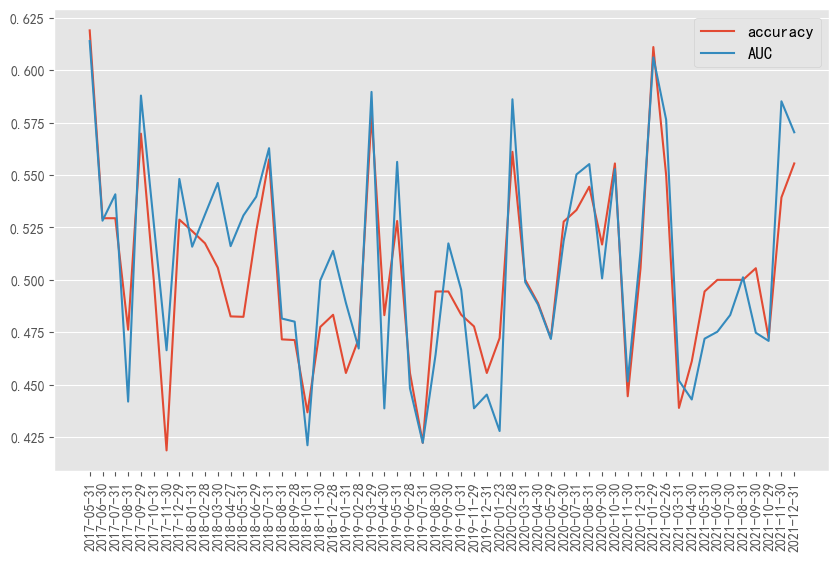

In [66]:
accu_1, auc_1, group_df1 = model_evaluation(knn, test_dict, trade_days_test, selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_1, auc_1)

作图成功!


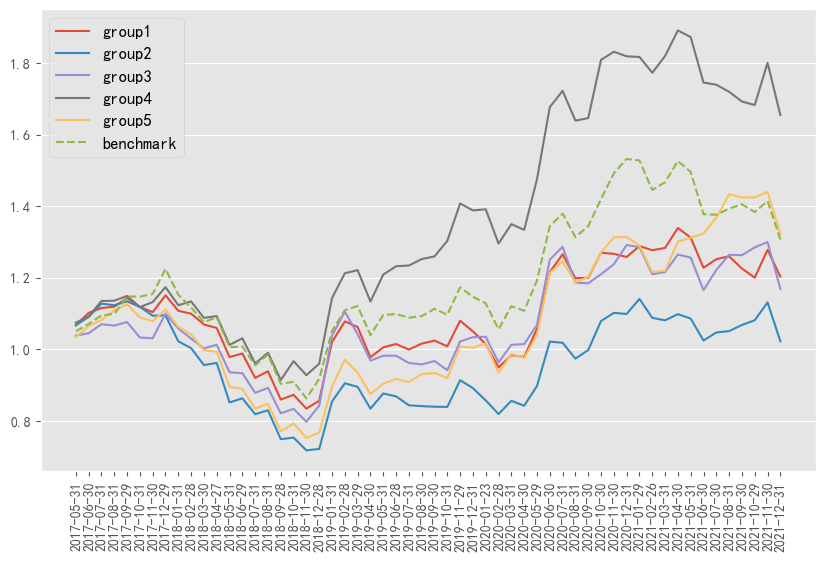

In [67]:
# 净值曲线
visualization(group_df1)

In [68]:
# 策略各项指标
eval1 = evaluation(group_df1)
eval1

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,20.3%,2.2%,16.8%,65.5%,32.2%,30.7%
年化收益率,4.04%,0.47%,3.38%,11.4%,6.16%,5.9%
最大回撤,27.57%,36.81%,27.52%,22.15%,33.24%,29.59%
夏普比率,0.01,-0.67,-0.11,1.38,0.41,0.39
年化超额收益率,-1.92%,-5.22%,-2.28%,5.18%,0.12%,0.0%
月最大超额收益,4.58%,4.13%,8.66%,5.17%,8.82%,0.0%
跑赢基准月份占比,44.64%,46.43%,42.86%,58.93%,46.43%,0.0%
正收益月份占比,51.79%,48.21%,53.57%,60.71%,58.93%,58.93%
信息比率,-0.92,-2.54,-1.04,2.57,0.11,NaN


### 5.4 Logistic Regression

**In-Sample Accuracy and AUC**

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
lg = LogisticRegression()

params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "max_iter": [100, 200, 300],
    "penalty": ["l1", "l2"],
}
lg_GS = GridSearchCV(estimator=lg, param_grid=params, cv=5)
lg_GS.fit(X_wrapper, y)

# 输出最佳模型结果
print(lg_GS.best_score_)  # 0.547038188631109
# 输出最佳模型参数
print(lg_GS.best_params_)  # {'C': 1000, 'max_iter': 300, 'penalty': 'l1'}

0.5313977798998502
{'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}


In [71]:
lg = LogisticRegression(C=1000, max_iter=300, penalty="l1", solver="liblinear")

In [72]:
print("样本内交叉验证 : ")
accuracy_train = cross_val_score(lg, X_wrapper, y, scoring="accuracy", cv=5).mean()
print("\t", "accuracy = %.4f" % (accuracy_train))  # accuracy = 0.5458

auc_train = cross_val_score(lg, X_wrapper, y, scoring="roc_auc", cv=5).mean()
print("\t", "auc = %.4f" % (auc_train))  # auc = 0.5637

样本内交叉验证 : 
	 accuracy = 0.5309
	 auc = 0.5452


In [73]:
lg.fit(X_wrapper, y)

LogisticRegression(C=1000, max_iter=300, penalty='l1', solver='liblinear')

**Out-of-Sample Stock Selection Strategy Performance**

精确度均值: 0.5135756708317251
AUC均值: 0.5188414498721498


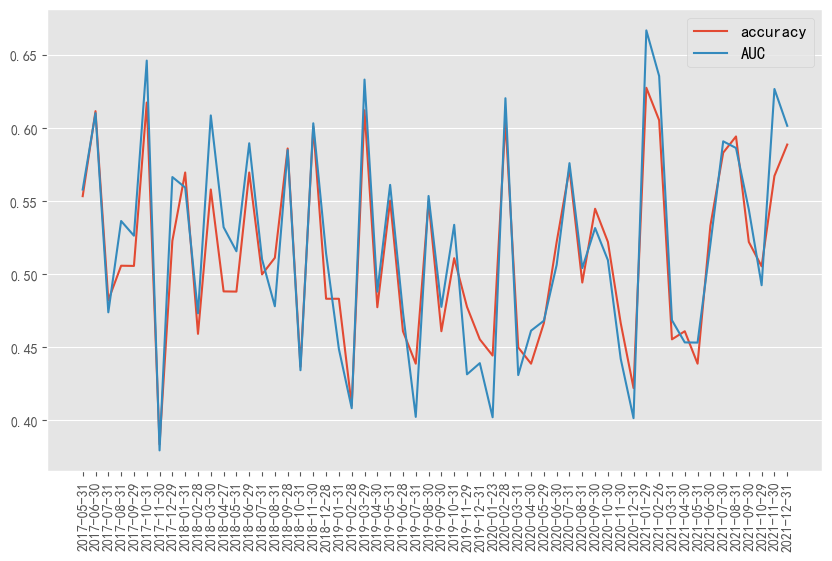

In [74]:
accu_2, auc_2, group_df2 = model_evaluation(lg, test_dict, trade_days_test, selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_2, auc_2)

作图成功!


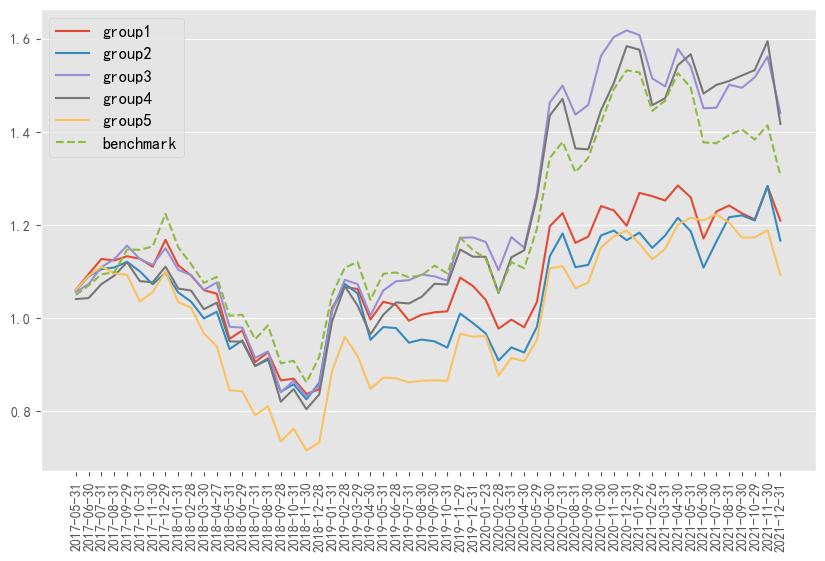

In [75]:
# 净值曲线
visualization(group_df2)

In [76]:
# 策略各项指标
eval2 = evaluation(group_df2)
eval2

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,20.9%,16.6%,44.1%,41.7%,9.3%,30.7%
年化收益率,4.15%,3.35%,8.14%,7.75%,1.92%,5.9%
最大回撤,28.35%,26.35%,28.03%,28.18%,35.54%,29.59%
夏普比率,0.03,-0.13,0.78,0.68,-0.37,0.39
年化超额收益率,-1.92%,-2.54%,2.14%,1.88%,-3.77%,0.0%
月最大超额收益,6.18%,5.12%,4.1%,4.13%,7.44%,0.0%
跑赢基准月份占比,44.64%,51.79%,55.36%,53.57%,41.07%,0.0%
正收益月份占比,48.21%,53.57%,55.36%,58.93%,51.79%,58.93%
信息比率,-0.7,-1.23,1.33,0.97,-1.51,NaN


### 5.5 Decision Tree

**In-Sample Accuracy and AUC**

In [77]:
from sklearn.tree import DecisionTreeClassifier

**Note: it takes 8 min**

In [78]:
has_tree_model = model_manager.has_model("tree")
if not has_tree_model:
    tree = DecisionTreeClassifier()
    params = {
        "criterion": ["gini", "entropy"],
        "max_depth": [*range(3, 8)],
        "min_samples_split": [2, 10, 20, 30, 60],
        "min_samples_leaf": [1, 5, 10, 20, 30],
    }
    tree_GS = GridSearchCV(estimator=tree, param_grid=params, cv=5)
    tree_GS.fit(X_wrapper, y)

    # 输出最佳模型结果
    print(tree_GS.best_score_)  # 0.5413377979749661
    # 输出最佳模型参数
    print(
        tree_GS.best_params_
    )  # {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 2}

In [79]:
if not has_tree_model:
    tree = DecisionTreeClassifier(
        criterion="entropy", max_depth=5, min_samples_leaf=30, min_samples_split=2
    )
else:
    tree = model_manager.load_model("tree")

In [80]:
print("样本内交叉验证 : ")
accuracy_train = cross_val_score(tree, X_wrapper, y, scoring="accuracy", cv=5).mean()
print("\t", "accuracy = %.4f" % (accuracy_train))
auc_train = cross_val_score(tree, X_wrapper, y, scoring="roc_auc", cv=5).mean()
print("\t", "auc = %.4f" % (auc_train))

样本内交叉验证 : 
	 accuracy = 0.5301
	 auc = 0.5383


In [81]:
tree.fit(X_wrapper, y)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=30)

In [82]:
if not has_tree_model:
    model_manager.save_model(tree, "tree")

**Out-of-Sample Stock Selection Strategy Performance**

精确度均值: 0.5192261564150024
AUC均值: 0.5283138025691895


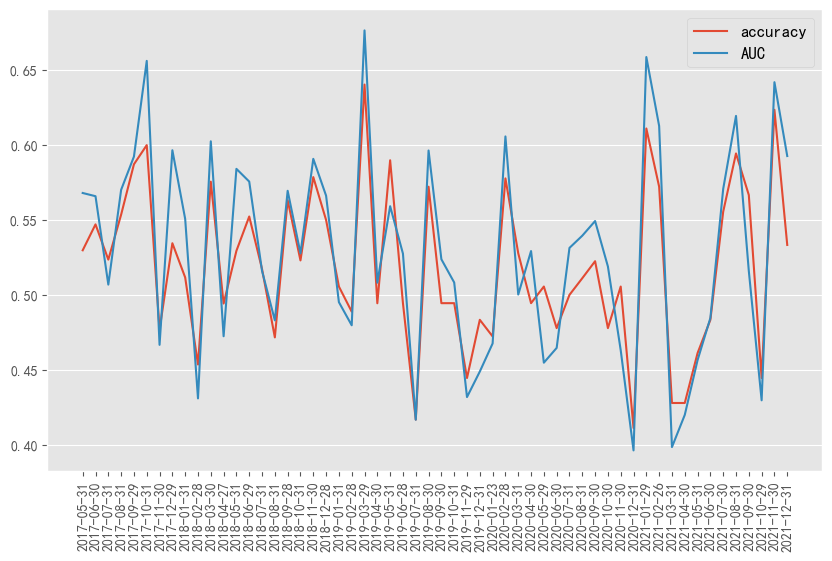

In [83]:
accu_3, auc_3, group_df3 = model_evaluation(tree, test_dict, trade_days_test, selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_3, auc_3)

作图成功!


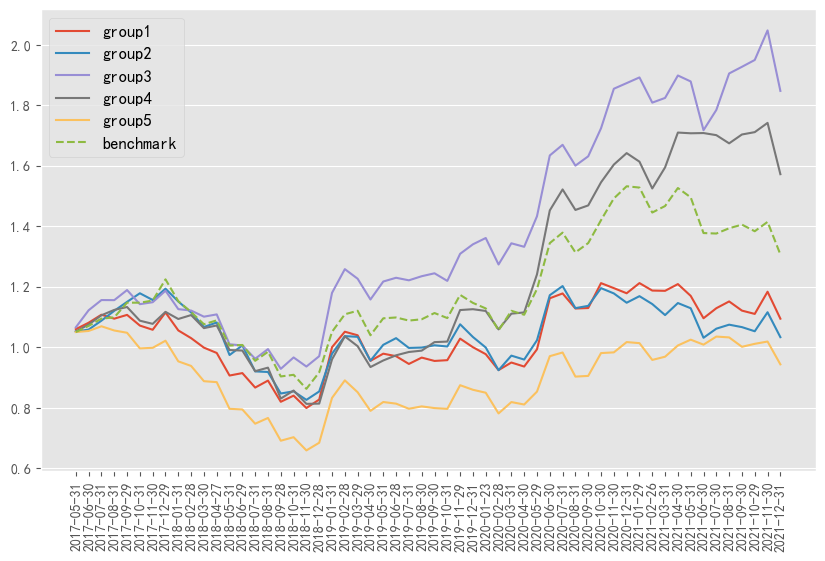

In [84]:
# 净值曲线
visualization(group_df3)

In [85]:
eval3 = evaluation(group_df3)
eval3

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,9.4%,3.3%,84.8%,57.2%,-5.7%,30.7%
年化收益率,1.94%,0.7%,14.06%,10.18%,-1.25%,5.9%
最大回撤,28.36%,30.83%,21.93%,28.29%,38.42%,29.59%
夏普比率,-0.38,-0.64,1.84,1.13,-0.94,0.39
年化超额收益率,-3.86%,-5.07%,7.78%,4.0%,-6.76%,0.0%
月最大超额收益,6.35%,3.74%,6.99%,7.95%,7.09%,0.0%
跑赢基准月份占比,48.21%,44.64%,62.5%,55.36%,33.93%,0.0%
正收益月份占比,46.43%,51.79%,62.5%,64.29%,48.21%,58.93%
信息比率,-1.7,-2.47,3.91,1.7,-2.91,NaN


### 5.6 Gaussian Naive Bayes

**In-Sample Accuracy and AUC**

In [86]:
from sklearn.naive_bayes import GaussianNB

In [87]:
# 这个是最简单的模型了,没有什么调的参数
bys = GaussianNB()

In [88]:
print("样本内交叉验证 : ")
accuracy_train = cross_val_score(bys, X_wrapper, y, scoring="accuracy", cv=5).mean()
print("\t", "accuracy = %.4f" % (accuracy_train))
auc_train = cross_val_score(bys, X_wrapper, y, scoring="roc_auc", cv=5).mean()
print("\t", "auc = %.4f" % (auc_train))

样本内交叉验证 : 
	 accuracy = 0.5323
	 auc = 0.5517


In [89]:
bys.fit(X_wrapper, y)

GaussianNB()

**Out-of-Sample Stock Selection Strategy Performance**

精确度均值: 0.5132485749082375
AUC均值: 0.5239880978602853


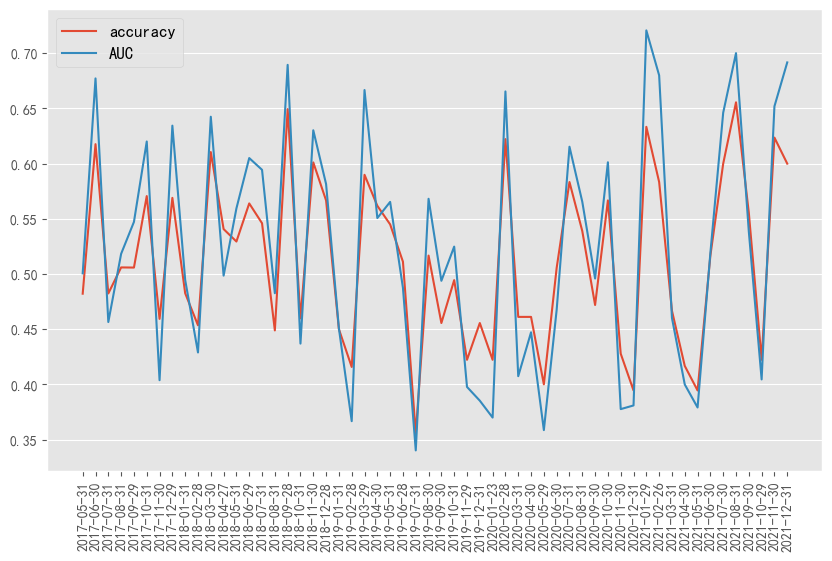

In [90]:
accu_4, auc_4, group_df4 = model_evaluation(bys, test_dict, trade_days_test, selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_4, auc_4)

作图成功!


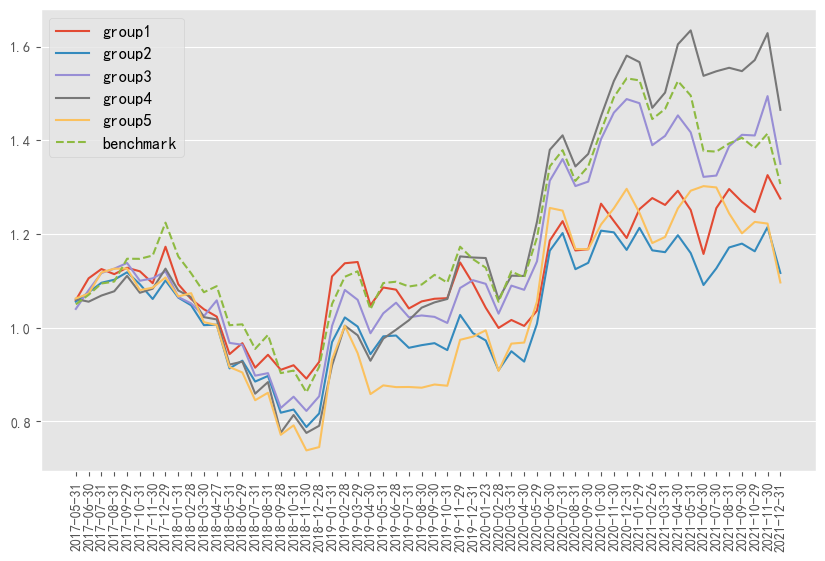

In [91]:
# 净值曲线
visualization(group_df4)

In [92]:
eval4 = evaluation(group_df4)
eval4

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,27.6%,11.7%,35.0%,46.5%,9.6%,30.7%
年化收益率,5.36%,2.4%,6.64%,8.53%,1.98%,5.9%
最大回撤,24.01%,29.55%,27.76%,31.15%,34.47%,29.59%
夏普比率,0.26,-0.3,0.51,0.83,-0.32,0.39
年化超额收益率,-0.93%,-3.4%,0.64%,2.58%,-3.51%,0.0%
月最大超额收益,8.57%,4.32%,3.8%,4.26%,10.47%,0.0%
跑赢基准月份占比,42.86%,42.86%,53.57%,55.36%,41.07%,0.0%
正收益月份占比,51.79%,53.57%,57.14%,60.71%,55.36%,58.93%
信息比率,-0.18,-1.73,0.4,1.33,-1.18,NaN


### 5.7 Random Forest

**In-Sample Accuracy and AUC**

In [93]:
from sklearn.ensemble import RandomForestClassifier

**Note：it takes 1h 46min**

In [94]:
has_rfc_model = model_manager.has_model("rfc")
if not has_rfc_model:
    rfc = RandomForestClassifier()
    params = {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [*range(3, 6)],
        "min_samples_split": [2, 10, 20, 30],
        "min_samples_leaf": [1, 5, 10, 20],
    }
    rfc_GS = GridSearchCV(estimator=rfc, param_grid=params, cv=5)
    rfc_GS.fit(X_wrapper, y)

    # 输出最佳模型结果
    print(rfc_GS.best_score_)  # 0.5486327034999602
    # 输出最佳模型参数
    print(rfc_GS.best_params_)

# 训练出来的最优参数为{'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 50}

In [95]:
if not has_rfc_model:
    rfc = RandomForestClassifier(
        n_estimators=50, max_depth=4, min_samples_leaf=10, min_samples_split=20
    )
else:
    rfc = model_manager.load_model("rfc")

In [96]:
print("样本内交叉验证 : ")
accuracy_train = cross_val_score(rfc, X_wrapper, y, scoring="accuracy", cv=5).mean()
print("\t", "accuracy = %.4f" % (accuracy_train))  # accuracy = 0.5474

auc_train = cross_val_score(rfc, X_wrapper, y, scoring="roc_auc", cv=5).mean()
print("\t", "auc = %.4f" % (auc_train))  # auc = 0.5667

样本内交叉验证 : 
	 accuracy = 0.5328
	 auc = 0.5482


In [98]:
rfc.fit(X_wrapper, y)

RandomForestClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=20,
                       n_estimators=50)

In [99]:
if not has_rfc_model:
    model_manager.save_model(rfc, "rfc")

**Out-of-Sample Stock Selection Strategy Performance**

精确度均值: 0.5138395334821936
AUC均值: 0.5305677106766084


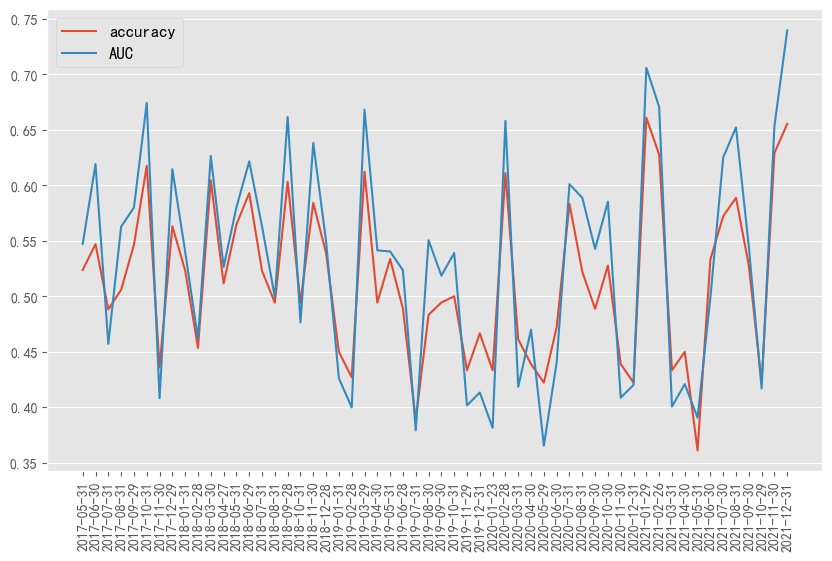

In [100]:
accu_5, auc_5, group_df5 = model_evaluation(rfc, test_dict, trade_days_test, selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_5, auc_5)

作图成功!


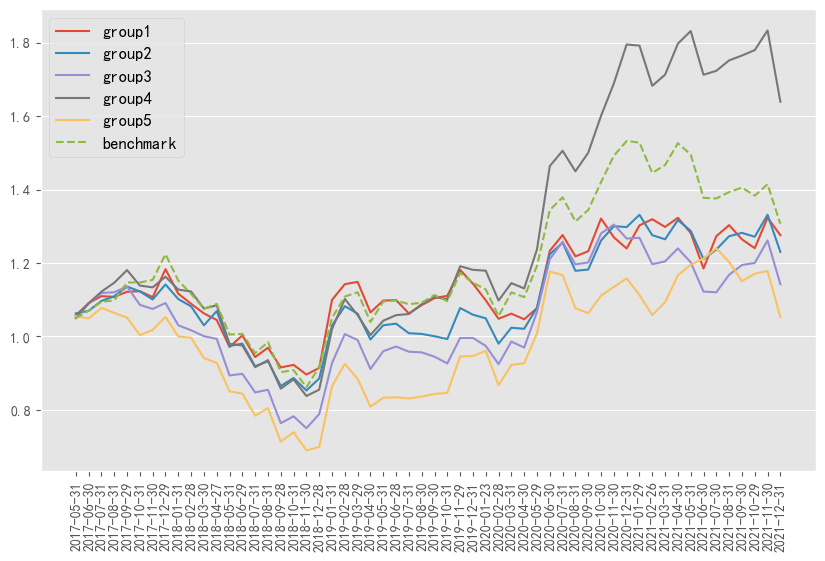

In [101]:
visualization(group_df5)

In [102]:
eval5 = evaluation(group_df5)
eval5

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,27.6%,23.0%,14.2%,63.9%,5.3%,30.7%
年化收益率,5.36%,4.54%,2.89%,11.17%,1.11%,5.9%
最大回撤,24.25%,25.3%,33.96%,29.04%,36.0%,29.59%
夏普比率,0.27,0.11,-0.21,1.27,-0.46,0.39
年化超额收益率,-0.98%,-1.48%,-2.79%,5.16%,-4.36%,0.0%
月最大超额收益,7.53%,2.86%,3.01%,5.58%,9.27%,0.0%
跑赢基准月份占比,50.0%,53.57%,44.64%,60.71%,44.64%,0.0%
正收益月份占比,55.36%,51.79%,53.57%,60.71%,55.36%,58.93%
信息比率,-0.18,-0.84,-1.51,2.56,-1.48,NaN


## 5.8 Adaboost

**In-Sample Accuracy and AUC**

In [103]:
from sklearn.ensemble import AdaBoostClassifier

In [122]:
has_adb_model = model_manager.has_model("adb")

In [120]:

if not has_adb_model:
    adb = AdaBoostClassifier()
    params = {
        "estimator": [DecisionTreeClassifier(max_depth=5)],
        "n_estimators": [50, 100, 200, 300],
        "learning_rate": [0.01, 0.1, 1, 10, 100],
    }
    adb_GS = GridSearchCV(estimator=adb, param_grid=params, cv=5)
    adb_GS.fit(X_wrapper, y)
    # 输出最佳模型结果
    print(adb_GS.best_score_)
    # 输出最佳模型参数
    print(adb_GS.best_params_)  #'learning_rate': 0.01, 'n_estimators': 200}

0.5356587209229898
{'estimator': DecisionTreeClassifier(max_depth=5), 'learning_rate': 0.1, 'n_estimators': 100}


模型最佳参数：{'estimator': DecisionTreeClassifier(max_depth=5), 'learning_rate': 0.1, 'n_estimators': 100}

In [ ]:

if not has_adb_model:
    adb = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=5), learning_rate=0.1, n_estimators=100
    )
else:
    adb = model_manager.load_model("adb")

In [125]:
print("样本内交叉验证 : ")
accuracy_train = cross_val_score(adb, X_wrapper, y, scoring="accuracy", cv=5).mean()
print("\t", "accuracy = %.4f" % (accuracy_train))  # accuracy = 0.5452

auc_train = cross_val_score(adb, X_wrapper, y, scoring="roc_auc", cv=5).mean()
print("\t", "auc = %.4f" % (auc_train))  # auc = 0.5617

样本内交叉验证 : 
	 accuracy = 0.5342
	 auc = 0.5493


In [126]:
adb.fit(X_wrapper, y)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=100)

In [127]:
if not has_adb_model:
    model_manager.save_model(adb, "adb")

**Out-of-Sample Stock Selection Strategy Performance**

精确度均值: 0.5130332725079072
AUC均值: 0.5270477332557307


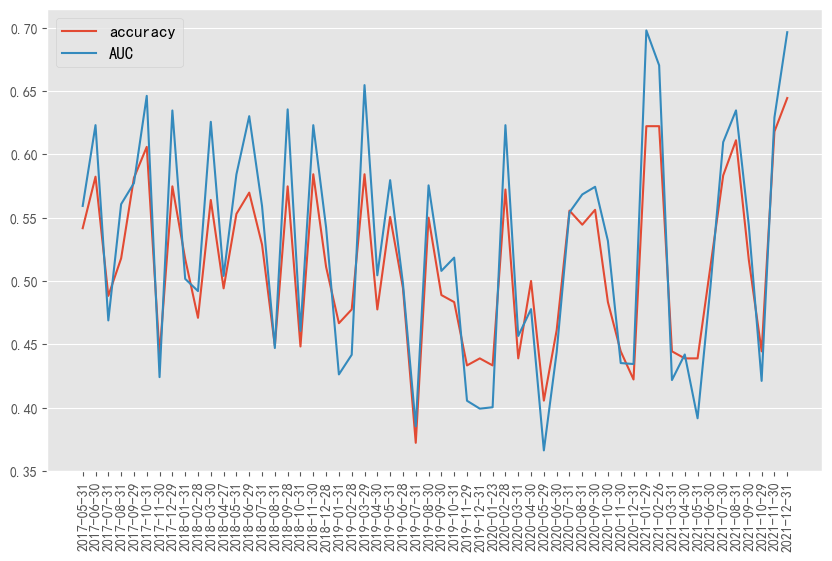

In [128]:
accu_6, auc_6, group_df6 = model_evaluation(adb, test_dict, trade_days_test, selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_6, auc_6)

作图成功!


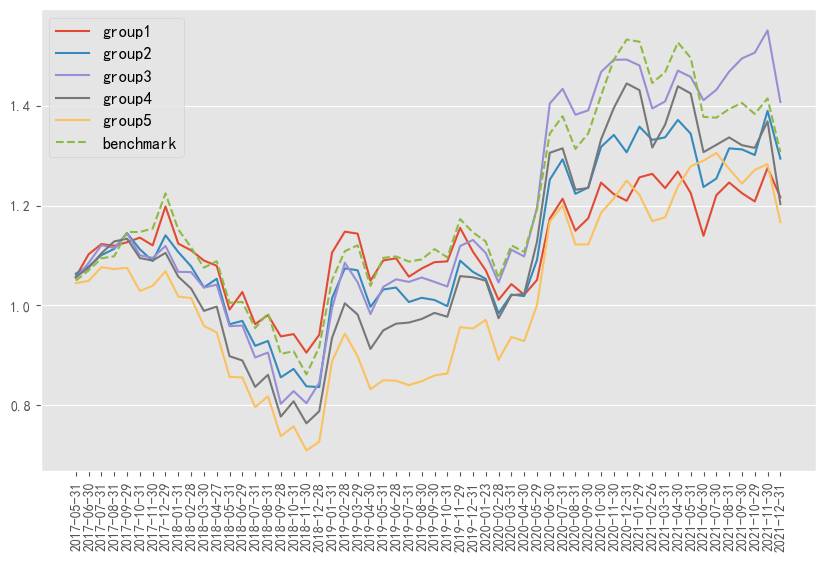

In [129]:
visualization(group_df6)

In [130]:
eval6 = evaluation(group_df6)
eval6

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,21.7%,29.4%,40.7%,20.3%,16.7%,30.7%
年化收益率,4.3%,5.68%,7.59%,4.04%,3.36%,5.9%
最大回撤,24.42%,26.91%,29.85%,32.61%,34.07%,29.59%
夏普比率,0.06,0.31,0.67,0.01,-0.11,0.39
年化超额收益率,-1.98%,-0.3%,1.6%,-1.47%,-2.39%,0.0%
月最大超额收益,7.25%,6.66%,4.71%,4.02%,8.78%,0.0%
跑赢基准月份占比,42.86%,55.36%,55.36%,48.21%,42.86%,0.0%
正收益月份占比,53.57%,51.79%,57.14%,57.14%,57.14%,58.93%
信息比率,-0.63,-0.1,0.83,-0.95,-0.91,NaN


### 5.9 SVM

**In-Sample Accuracy and AUC**

In [105]:
from sklearn.svm import SVC

In [106]:
# 参考华泰研报的结果选择参数, 也可以自己网格搜索一下
svm = SVC(C=0.003, kernel="rbf", gamma=0.01)

In [107]:
print("样本内交叉验证 : ")
accuracy_train = cross_val_score(svm, X_wrapper, y, scoring="accuracy", cv=5).mean()
print("\t", "accuracy = %.4f" % (accuracy_train))

auc_train = cross_val_score(svm, X_wrapper, y, scoring="roc_auc", cv=5).mean()
print("\t", "auc = %.4f" % (auc_train))

样本内交叉验证 : 
	 accuracy = 0.5041
	 auc = 0.5460


In [108]:
svm.fit(X_wrapper, y)

SVC(C=0.003, gamma=0.01)

**Out-of-Sample Stock Selection Strategy Performance**

精确度均值: 0.5139779458303482
AUC均值: 0.5208009405341364


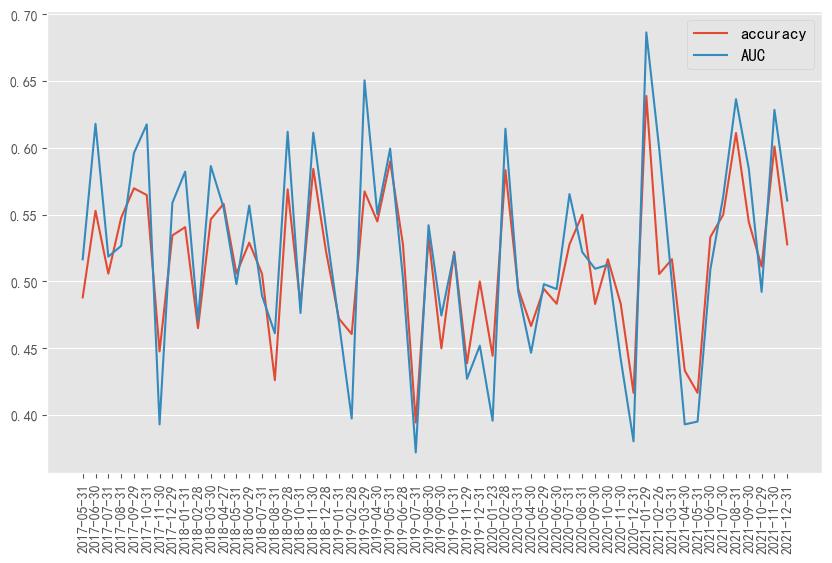

In [110]:
accu_7, auc_7, group_df7 = model_evaluation(svm, test_dict, trade_days_test, selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_7, auc_7)

作图成功!


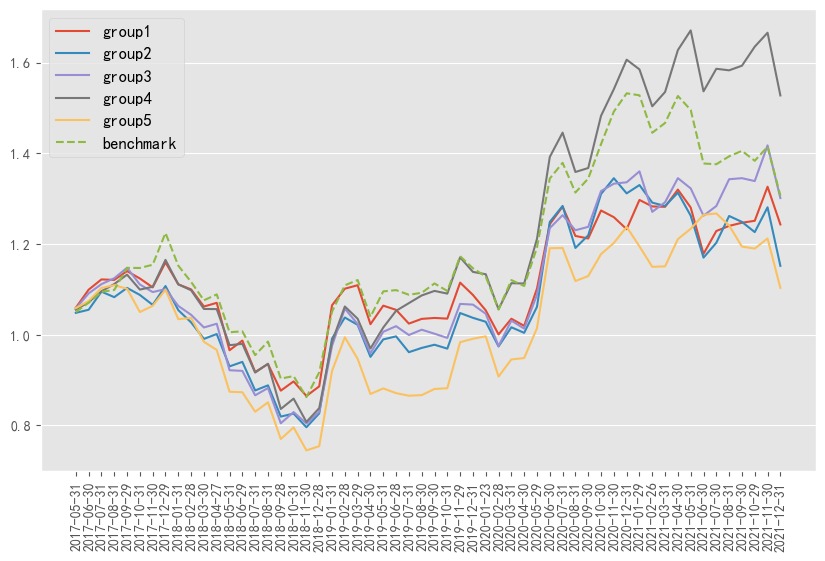

In [111]:
visualization(group_df7)

In [112]:
eval7 = evaluation(group_df7)
eval7

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,24.3%,15.2%,30.1%,52.8%,10.3%,30.7%
年化收益率,4.77%,3.08%,5.8%,9.51%,2.12%,5.9%
最大回撤,25.43%,28.14%,29.95%,30.7%,32.87%,29.59%
夏普比率,0.15,-0.17,0.35,1.01,-0.32,0.39
年化超额收益率,-1.29%,-2.66%,-0.24%,3.54%,-3.6%,0.0%
月最大超额收益,5.59%,5.36%,3.64%,4.68%,10.41%,0.0%
跑赢基准月份占比,41.07%,48.21%,50.0%,50.0%,41.07%,0.0%
正收益月份占比,51.79%,51.79%,55.36%,60.71%,60.71%,58.93%
信息比率,-0.49,-1.4,-0.05,2.03,-1.25,NaN


### 5.10 XGBoost

**In-Sample Accuracy and AUC**

In [113]:
from xgboost import XGBClassifier

In [114]:
xgb = XGBClassifier(n_estimators=200, max_depth=5)
print("样本内交叉验证 : ")
accuracy_train = cross_val_score(xgb, X_wrapper, y, scoring="accuracy", cv=5).mean()
print("\t", "accuracy = %.4f" % (accuracy_train))

auc_train = cross_val_score(xgb, X_wrapper, y, scoring="roc_auc", cv=5).mean()
print("\t", "auc = %.4f" % (auc_train))

样本内交叉验证 : 
	 accuracy = 0.5098
	 auc = 0.5173


In [115]:
xgb.fit(X_wrapper, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

**Out-of-Sample Stock Selection Strategy Performance**

精确度均值: 0.51408983223572
AUC均值: 0.5168851632951619


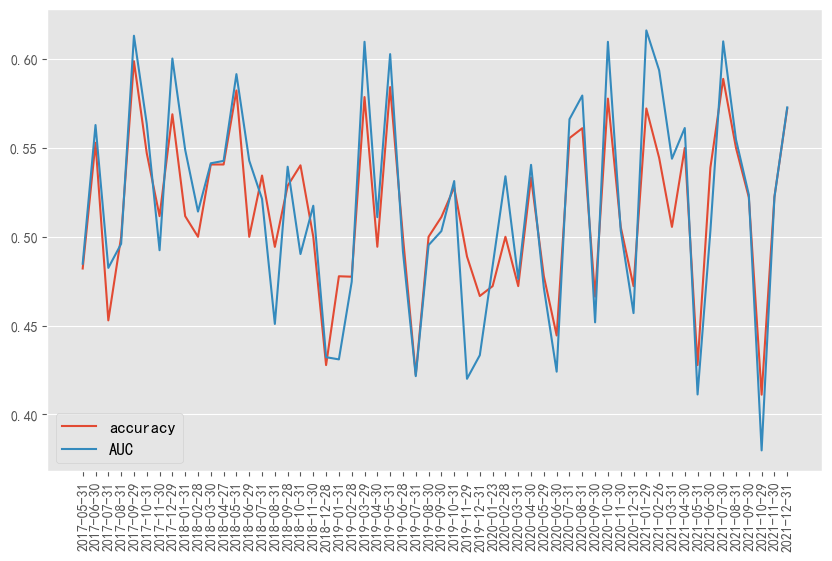

In [172]:
accu_8, auc_8, group_df8 = model_evaluation(xgb, test_dict, trade_days_test, selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_8, auc_8)

作图成功!


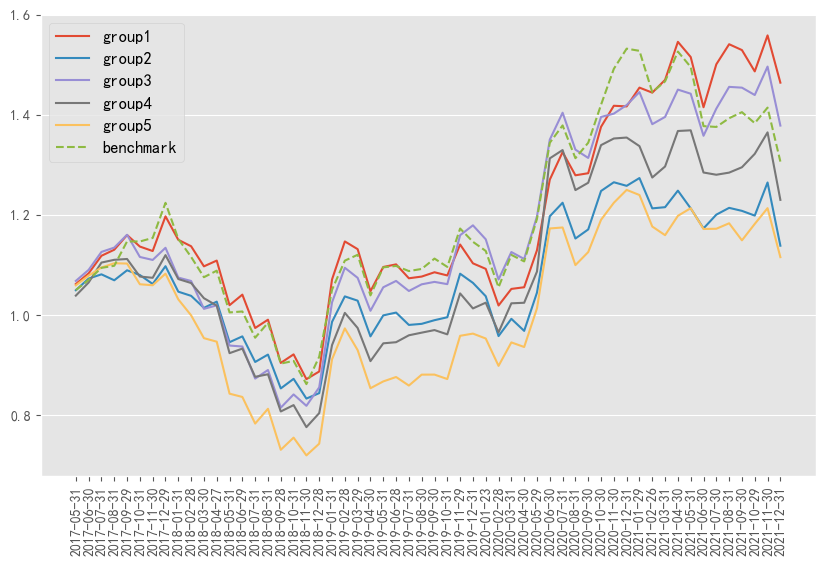

In [117]:
visualization(group_df8)

In [118]:
eval8 = evaluation(group_df8)
eval8

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,46.4%,13.9%,37.9%,23.0%,11.6%,30.7%
年化收益率,8.51%,2.83%,7.13%,4.54%,2.38%,5.9%
最大回撤,27.18%,24.1%,29.78%,30.7%,34.8%,29.59%
夏普比率,0.87,-0.24,0.6,0.1,-0.28,0.39
年化超额收益率,2.37%,-3.11%,1.08%,-1.28%,-3.25%,0.0%
月最大超额收益,6.18%,4.61%,5.25%,8.05%,8.07%,0.0%
跑赢基准月份占比,51.79%,42.86%,48.21%,48.21%,48.21%,0.0%
正收益月份占比,57.14%,55.36%,55.36%,62.5%,53.57%,58.93%
信息比率,1.3,-1.71,0.63,-0.65,-1.45,NaN


## Summary

In [131]:
models = [
    "KNN",
    "Logistic",
    "DecisionTree",
    "Bayes",
    "RF",
    "AdaBoost",
    "SVM",
    "XGBoost",
]

### Out-of-Sample Accuracy and AUC for Each Model

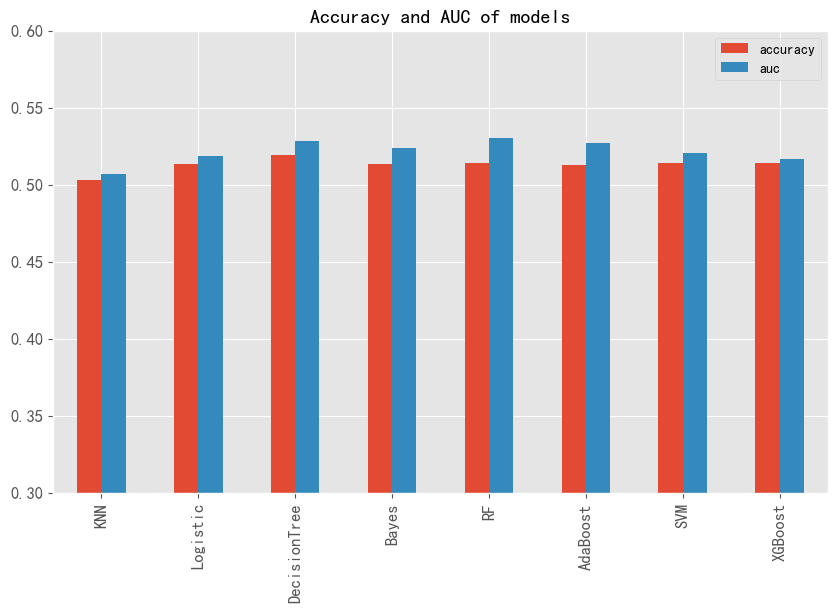

In [134]:
df = pd.DataFrame(
    [
        [
            np.mean(accu_1),
            np.mean(accu_2),
            np.mean(accu_3),
            np.mean(accu_4),
            np.mean(accu_5),
            np.mean(accu_6),
            np.mean(accu_7),
            np.mean(accu_8),
        ],
        [
            np.mean(auc_1),
            np.mean(auc_2),
            np.mean(auc_3),
            np.mean(auc_4),
            np.mean(auc_5),
            np.mean(auc_6),
            np.mean(auc_7),
            np.mean(auc_8),
        ],
    ],
    index=["accuracy", "auc"],
).T
df.index = models

df.plot(
    kind="bar",
    figsize=(10, 6),
    ylim=[0.3, 0.6],
    title="Accuracy and AUC of models",
    fontsize=12,
)

plt.show()

### The Net Value Curves of Portfolio 1 for Each Model

In [135]:
group1_all = pd.DataFrame(index=group_df1.index, columns=models + ["benchmark"])

In [136]:
for i, df in enumerate(
    [
        group_df1,
        group_df2,
        group_df3,
        group_df4,
        group_df5,
        group_df6,
        group_df7,
        group_df8,
    ]
):
    if i == 7:
        group1_all.iloc[:, i + 1] = df["benchmark"]
    group1_all.iloc[:, i] = df["group1"]

In [137]:
(group1_all + 1).cumprod().iloc[-1, :].sort_values()

DecisionTree    1.094078
KNN             1.202780
Logistic        1.209403
AdaBoost        1.216668
SVM             1.242933
Bayes           1.275546
RF              1.275846
benchmark       1.306592
XGBoost         1.464311
Name: 2021-12-31, dtype: float64

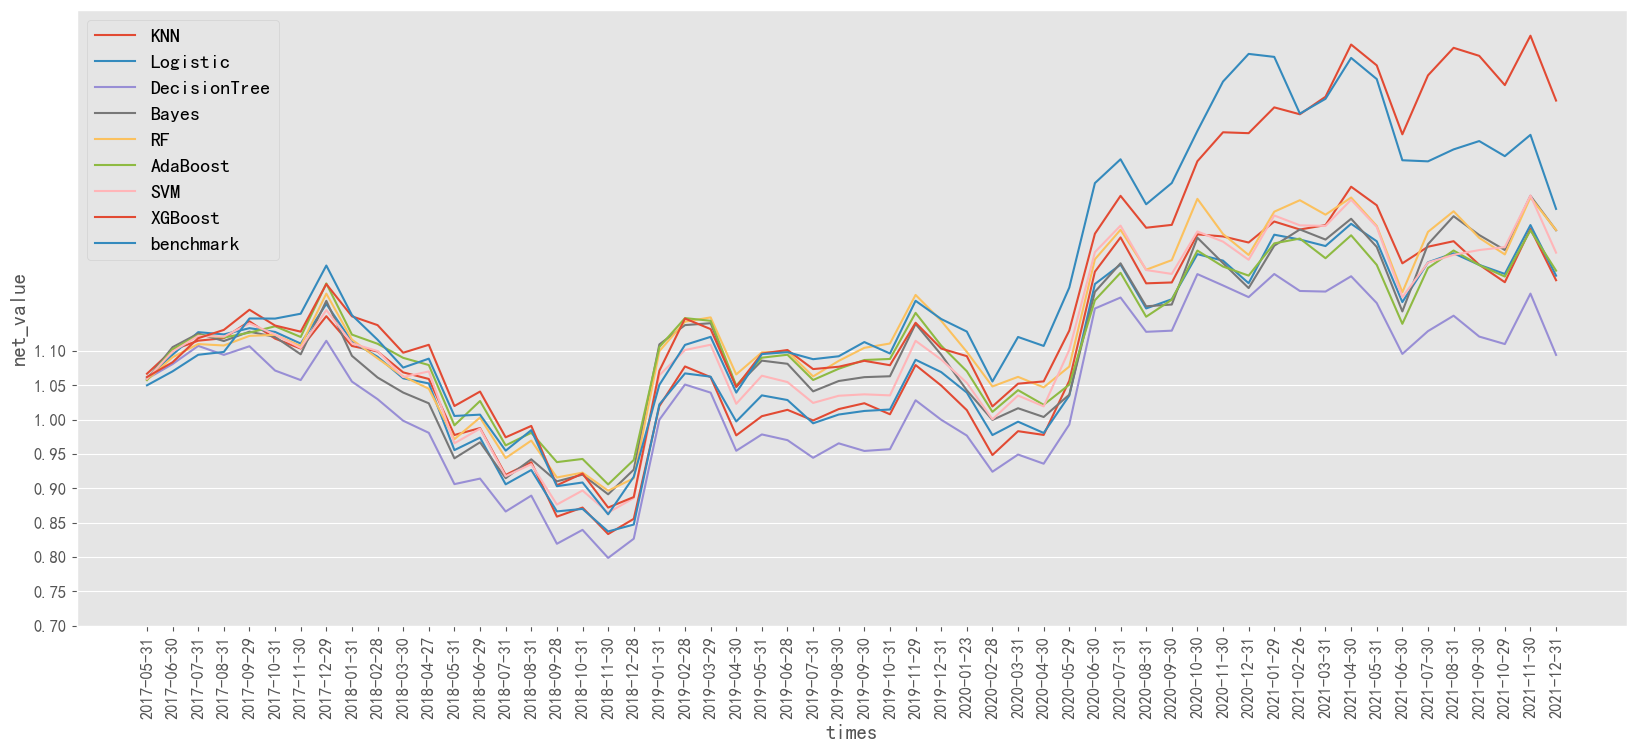

In [138]:
plt.figure(figsize=(20, 8))
group1_all.index = [str(i) for i in group1_all.index]
plt.plot((group1_all + 1).cumprod())
plt.xlabel("times", fontsize=15)
plt.ylabel("net_value", fontsize=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks([0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1], fontsize=12)
plt.legend(group1_all.columns, fontsize="x-large")
plt.grid(axis="x")
plt.show()

### Strategy Evaluation Indicators for Portfolio 1 of Each Model

In [139]:
eval_df = pd.DataFrame(index=eval1.index, columns=models)

In [141]:
(8.51 - 5.9) / 5.9

0.44237288135593206

In [142]:
(29.59 - 27.18) / 27.18

0.08866813833701251

In [140]:
for i, df in enumerate([eval1, eval2, eval3, eval4, eval5, eval6, eval7, eval8]):
    if i == 7:
        eval_df["benchmark"] = df["比较基准"]
    eval_df.iloc[:, i] = df["第一组"]

eval_df

,KNN,Logistic,DecisionTree,Bayes,RF,AdaBoost,SVM,XGBoost,benchmark
累计收益率,20.3%,20.9%,9.4%,27.6%,27.6%,21.7%,24.3%,46.4%,30.7%
年化收益率,4.04%,4.15%,1.94%,5.36%,5.36%,4.3%,4.77%,8.51%,5.9%
最大回撤,27.57%,28.35%,28.36%,24.01%,24.25%,24.42%,25.43%,27.18%,29.59%
夏普比率,0.01,0.03,-0.38,0.26,0.27,0.06,0.15,0.87,0.39
年化超额收益率,-1.92%,-1.92%,-3.86%,-0.93%,-0.98%,-1.98%,-1.29%,2.37%,0.0%
月最大超额收益,4.58%,6.18%,6.35%,8.57%,7.53%,7.25%,5.59%,6.18%,0.0%
跑赢基准月份占比,44.64%,44.64%,48.21%,42.86%,50.0%,42.86%,41.07%,51.79%,0.0%
正收益月份占比,51.79%,48.21%,46.43%,51.79%,55.36%,53.57%,51.79%,57.14%,58.93%
信息比率,-0.92,-0.7,-1.7,-0.18,-0.18,-0.63,-0.49,1.3,NaN
